# Solutions Task 3
Author: Luis Denninger, Leon Herbrik


The solutions of this task use our custom package "TorchGadgets" that bundles all useful functions for training, visualization etc. that we developed throughout the course of this lab and more. We choose to import redundant code from the package rather than making the notebook unnecessary long. We weren't sure what would be the best way to present the solutions to you. So we added the files from the package to the GitLab repository. Otherwise, the GitHub repository of the package can be accessed through: https://github.com/LDenninger/TorchGadgets


For convenience and fast browsing here a short summary of the most important used modules and where to find them:
 - class `NeuralNetwork`: `/torchgadgets/models/NeuralNetwork.py`
 - class `Logger`: `/torchgadgets/logging/Logger.py`
 - function `trainNN()`: `/torchgadgets/training/model_training.py`
 - Visualizations: `/torchgadgets/visualization`
 - Backbone models : `/torchgadgets/models/feature_extractor.py`


In [1]:
import os
from functools import reduce
from pathlib import Path as P

import numpy as np

import torch
import torch.nn 
import torch.nn.functional as fun
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data_utils
from torch.utils.tensorboard import SummaryWriter

import torchvision as tv

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec 
import matplotlib.patches as patches
import seaborn as sn
from sklearn.metrics import confusion_matrix

import yaml

import copy

from tqdm import tqdm

import optuna

import pandas as pd

import plotly

from fvcore.nn import FlopCountAnalysis, flop_count_str, ActivationCountAnalysis

import ipdb

import inspect

import torchgadgets as tg


## Data


In [2]:

tg.tools.set_random_seed(42)

data = tg.data.load_dataset('oxfordpet')


train_dataset = data['train_dataset']
test_dataset = data['test_dataset']

dog_inds = [1, 2, 3, 4, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21,22, 24, 25, 28, 29, 30, 31, 34, 35, 36]
cat_inds = [0, 5, 6, 7, 8, 11, 20, 23, 26, 27, 32, 33]

category_names = [
    'abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle',
    'bengal', 'birman', 'bombay', 'boxer', 'british_shorthair', 'chihuahua', 'egyptian_mau',
    'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees',
    'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'maine_coon', 'miniature_pinscher',
    'newfoundland', 'persian', 'pomeranian', 'pug', 'ragdoll', 'russian_blue', 'saint_bernard',
    'samoyed', 'scottish_terrier', 'shiba_inu', 'siamese', 'sphynx', 'staffordshire_bull_terrier',
    'wheaten_terrier', 'yorkshire_terrier'
]

print('Train dataset size: {}'.format(len(train_dataset)))
print('Test dataset size: {}'.format(len(test_dataset)))


Train dataset size: 3680
Test dataset size: 3669


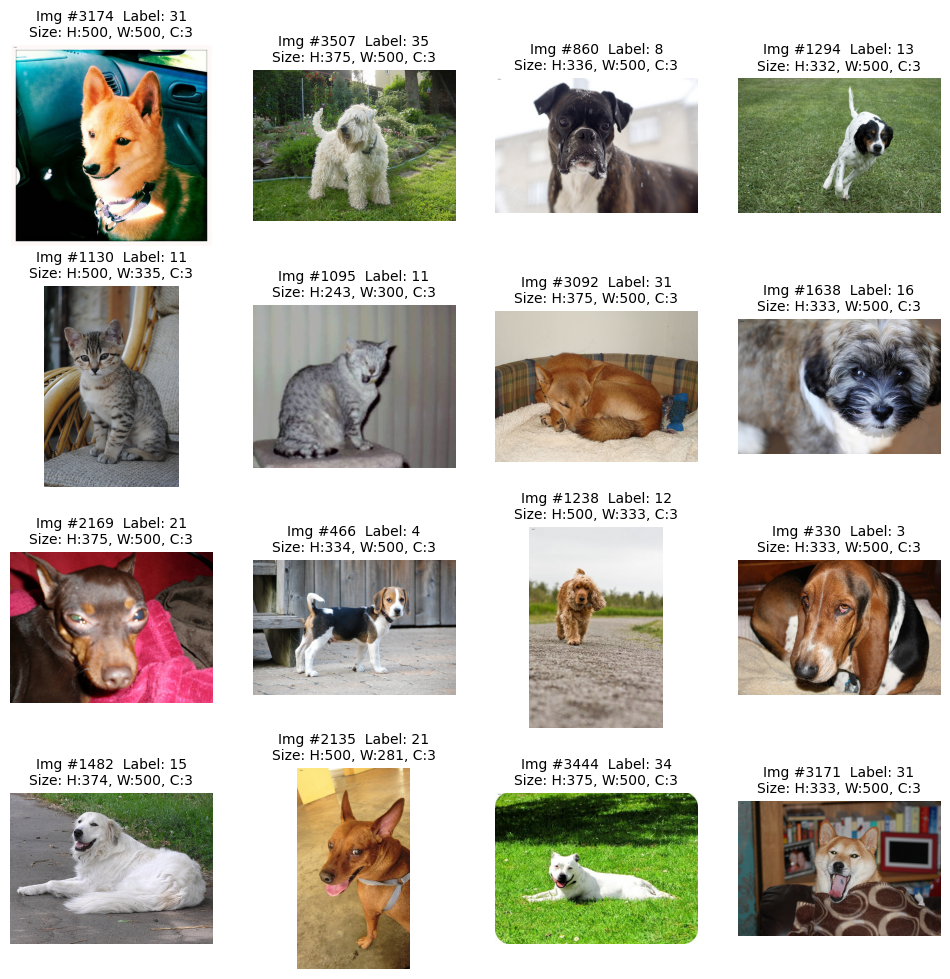

In [3]:
tg.visualization.visualize_dataset(test_dataset)

## Data Augmentation
The images loaded from our dataset are cropped to a uniform image size of 224x244. For the training images we take a random crop of the image and resize it to 224x244. For the test dataset we take a quadratic crop around the center that spans the minimum of the image width and height, to include as much information as possible in the crop. The models that we train "without augmentation" still include augmentation in form of a random crop. The further augmentations applied to the images are:
 - MixUp (alpha: 1.0, probability: 0.5, beta: 1.0)
 - Random Rotation (Maximum Degree: 5)
 - Random Horizontal Flip (probability: 0.3)
 - Color Jitter (brightness: (0.6, 1.4), contrast: (0.6, 1.4), saturation: (0.7, 1.3))
 - Gaussian Blur (kernel size: (5,5), sigma: (0.1, 2.0))

In our experiments, we were not able to get proper results using CutMix. Both implementations taken from our package are provided below.

In [4]:
# Take a random crop and resize the image to 224x224 to enforce the same size for all images to concatenate them to batches.
data_loading_transforms = [ {'type': 'convert_255_to_1','train': True, 'eval': True}, 
                            {'type': 'random_resized_crop', 'size': (224, 224), 'scale': (0.08,1.0), 'ratio': (0.75, 1.3333), 'train': True, 'eval': False}
                             ]

test_data_loading_transforms = [{'type': 'convert_255_to_1','train': True, 'eval': True},
                                {'type': 'dynamic_center_crop', 'train': False, 'eval': True},
                                {'type': 'resize', 'size': (224,224), 'train': False, 'eval': True}]

# All other transformations are applied to batches of images after data loading for higher computational efficiency.

tg.tools.set_random_seed(42)

# Define a custom dataset including the data augmentation and further functions to edit the dataset.
train_augmentation_dataset = tg.data.ImageDataset(train_dataset, data_loading_transforms)
test_augmentation_dataset = tg.data.ImageDataset(test_dataset, test_data_loading_transforms, train_set=False)




### Implementation

These are the implementations of the two advanced data augmentation techniques from our package that are used in our data augmentation pipeline.


#### MixUp

```python

def _mixup(self, input: tuple):
    """
        Implementation of the data augmentation technique as described in: "mixup: beyond empirical risk minimization" <https://arxiv.org/pdf/1710.09412.pdf>
    """

    device = input[0].device
    rand_index = torch.randperm(input[0].shape[0]).to(device)
    target_pairs = input[1][rand_index]
    batch_pairs = input[0][rand_index]

    target_ohc = torch.nn.functional.one_hot(input[1], num_classes=self.mixup_classes)
    target_pairs_ohc = torch.nn.functional.one_hot(target_pairs, num_classes=self.mixup_classes)

    lam = self.mixup_beta.sample() # sample from beta distribution

    return (lam * input[0] + (1 - lam) * batch_pairs, lam * target_ohc + (1 - lam) * target_pairs_ohc)

```

#### CutMix

```python
def _cutmix(self, input: tuple):
    """
        Implementation of the data augmentation technique as described in: 
            "CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features" <https://arxiv.org/pdf/1905.04899.pdf>.
        This code is an adaptation from: https://github.com/clovaai/CutMix-PyTorch
    """

    def _rand_bbox(size, lam):
        W = size[2]
        H = size[3]
        cut_rat = np.sqrt(1. - lam)
        cut_w = int(W * cut_rat)
        cut_h = int(H * cut_rat)

        # uniform
        cx = np.random.randint(W)
        cy = np.random.randint(H)

        bbx1 = np.clip(cx - cut_w // 2, 0, W)
        bby1 = np.clip(cy - cut_h // 2, 0, H)
        bbx2 = np.clip(cx + cut_w // 2, 0, W)
        bby2 = np.clip(cy + cut_h // 2, 0, H)

        return bbx1, bby1, bbx2, bby2
    device = input[0].device
    # generate mixed sample
    lam = self.cutmix_beta.sample() # sample from beta distribution
    rand_index = torch.randperm(input[0].shape[0]).to(device)
    target_pairs = input[1][rand_index]
    batch_pairs = input[0][rand_index]
    bbx1, bby1, bbx2, bby2 = _rand_bbox(batch_pairs.shape, lam)
    batch_pairs[:, :, bbx1:bbx2, bby1:bby2] = batch_pairs[rand_index, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (input[0].shape[-1] * input[0].shape[-2]))
    target = torch.nn.functional.one_hot(input[1], num_classes=self.cutmix_classes) * lam + (1 - lam) * torch.nn.functional.one_hot(target_pairs, num_classes=self.cutmix_classes)
    return (batch_pairs, target)


```

In [5]:
###--- MixUp ---###
# This is the implementation we use throughout the notebook.

def _mixup(self, input: tuple):
    """
        Implementation of the data augmentation technique as described in: "mixup: beyond empirical risk minimization" <https://arxiv.org/pdf/1710.09412.pdf>
    """

    device = input[0].device
    rand_index = torch.randperm(input[0].shape[0]).to(device)
    target_pairs = input[1][rand_index]
    batch_pairs = input[0][rand_index]

    target_ohc = torch.nn.functional.one_hot(input[1], num_classes=self.mixup_classes)
    target_pairs_ohc = torch.nn.functional.one_hot(target_pairs, num_classes=self.mixup_classes)

    lam = self.mixup_beta.sample() # Sample beta distribution

    return (lam * input[0] + (1 - lam) * batch_pairs, lam * target_ohc + (1 - lam) * target_pairs_ohc)

In [6]:
###--- MixUp ---###
# This is the implementation we use throughout the notebook.

def _cutmix(self, input: tuple):
    """
        Implementation of the data augmentation technique as described in: "CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features" <https://arxiv.org/pdf/1905.04899.pdf>
        This code is an adaptation from: https://github.com/clovaai/CutMix-PyTorch
    """

    def _rand_bbox(size, lam):
        W = size[2]
        H = size[3]
        cut_rat = np.sqrt(1. - lam)
        cut_w = int(W * cut_rat)
        cut_h = int(H * cut_rat)

        # uniform
        cx = np.random.randint(W)
        cy = np.random.randint(H)

        bbx1 = np.clip(cx - cut_w // 2, 0, W)
        bby1 = np.clip(cy - cut_h // 2, 0, H)
        bbx2 = np.clip(cx + cut_w // 2, 0, W)
        bby2 = np.clip(cy + cut_h // 2, 0, H)

        return bbx1, bby1, bbx2, bby2
    device = input[0].device
    # generate mixed sample
    lam = self.cutmix_beta.sample()
    rand_index = torch.randperm(input[0].shape[0]).to(device)
    target_pairs = input[1][rand_index]
    batch_pairs = input[0][rand_index]
    bbx1, bby1, bbx2, bby2 = _rand_bbox(batch_pairs.shape, lam)
    batch_pairs[:, :, bbx1:bbx2, bby1:bby2] = batch_pairs[rand_index, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (input[0].shape[-1] * input[0].shape[-2]))
    target = torch.nn.functional.one_hot(input[1], num_classes=self.cutmix_classes) * lam + (1 - lam) * torch.nn.functional.one_hot(target_pairs, num_classes=self.cutmix_classes)
    return (batch_pairs, target)
  

### Conversion to Reduced Dataset

In [7]:
# Create mapping from original labels to dog (0) and cat (1) labels.
label_mapping = {}
for i in range(37):
    label_mapping[str(i)] = 0 if i in dog_inds else 1
# Remap the categories to dogs and cats within the dataset
train_augmentation_dataset.remap_labels(label_mapping)
test_augmentation_dataset.remap_labels(label_mapping)

# Take random 1000 random cat and 1000 random dog images.
CAT_IMAGES = 1000
DOG_IMAGES = 1000
random_inds = np.arange(len(train_augmentation_dataset))
np.random.shuffle(random_inds)

random_cat_inds = []
random_dog_inds = []
for i in random_inds:
    if len(random_cat_inds) >= CAT_IMAGES and len(random_dog_inds) >= DOG_IMAGES:
        break
    img, label = train_augmentation_dataset[i]
    if label == 0 and len(random_dog_inds) < DOG_IMAGES:
        random_dog_inds.append(i)
    elif label == 1 and len(random_cat_inds) < CAT_IMAGES:
        random_cat_inds.append(i)

train_augmentation_dataset.filter_dataset((random_cat_inds+random_dog_inds))


### Training Dataset

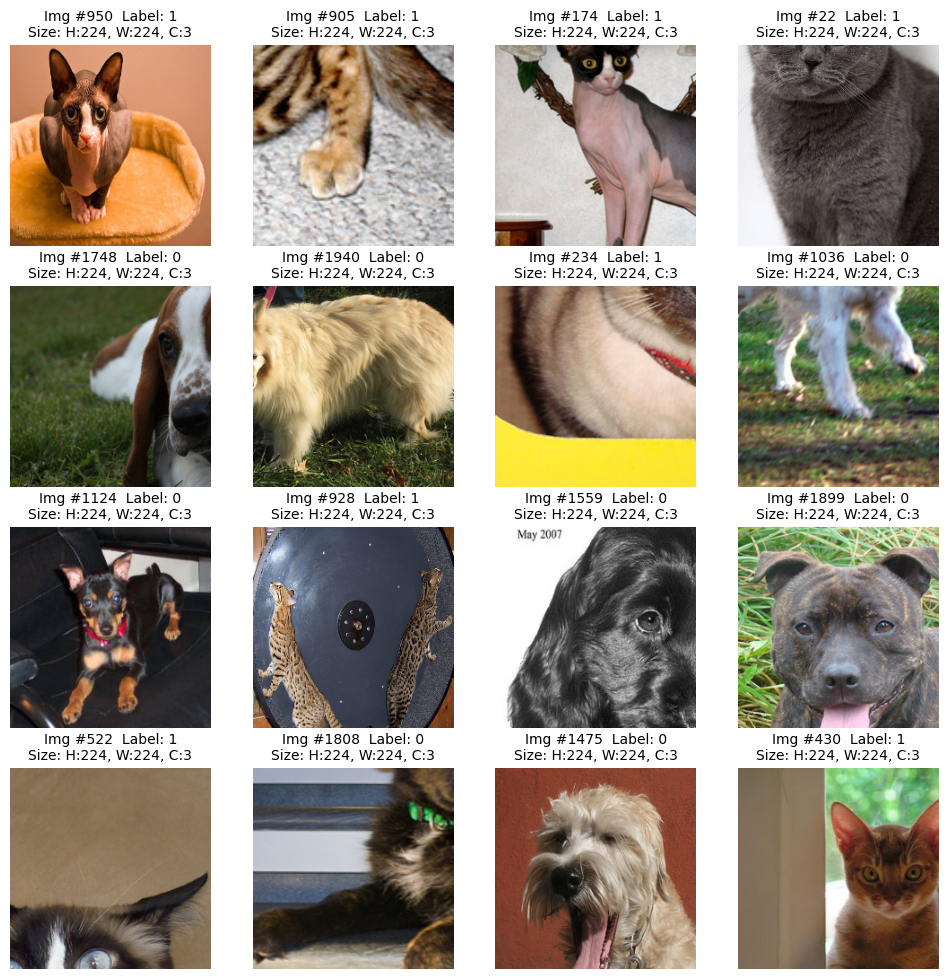

In [8]:
tg.visualization.visualize_dataset(train_augmentation_dataset)

### Test Dataset

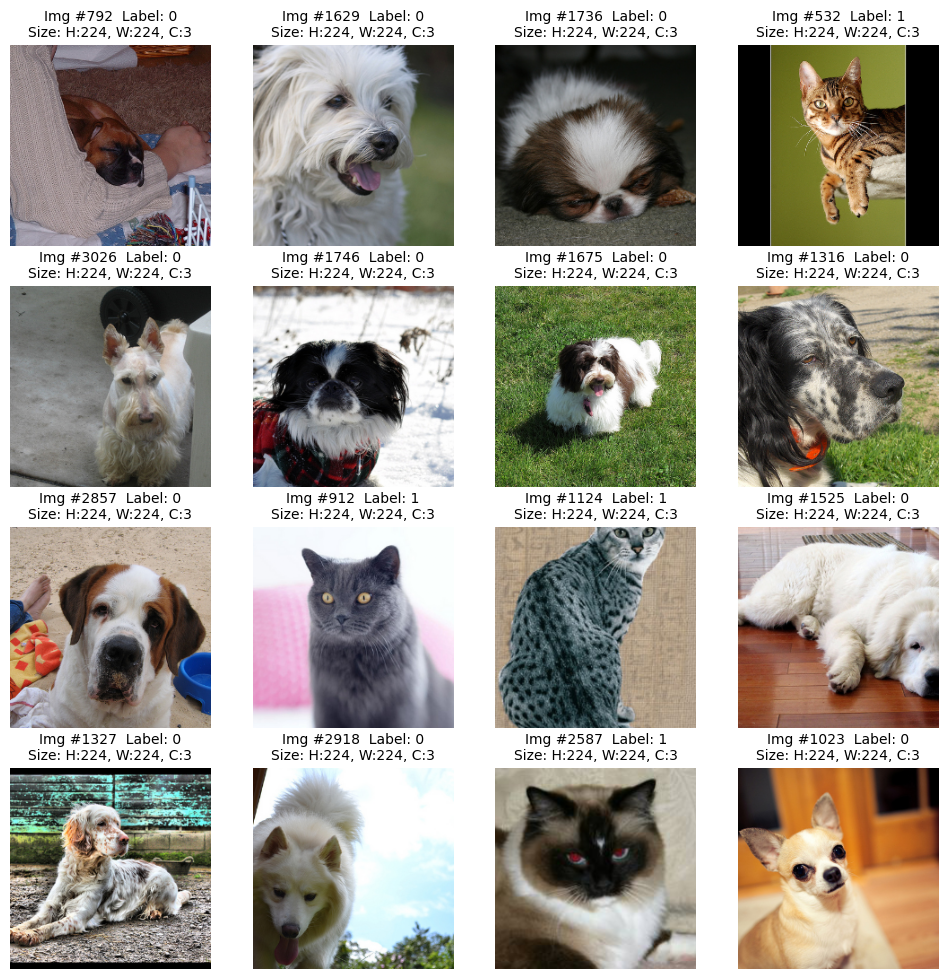

In [9]:
tg.visualization.visualize_dataset(test_augmentation_dataset)


### Augmented Dataset

Here are the final training images from our data augmentation pipeline as described above

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


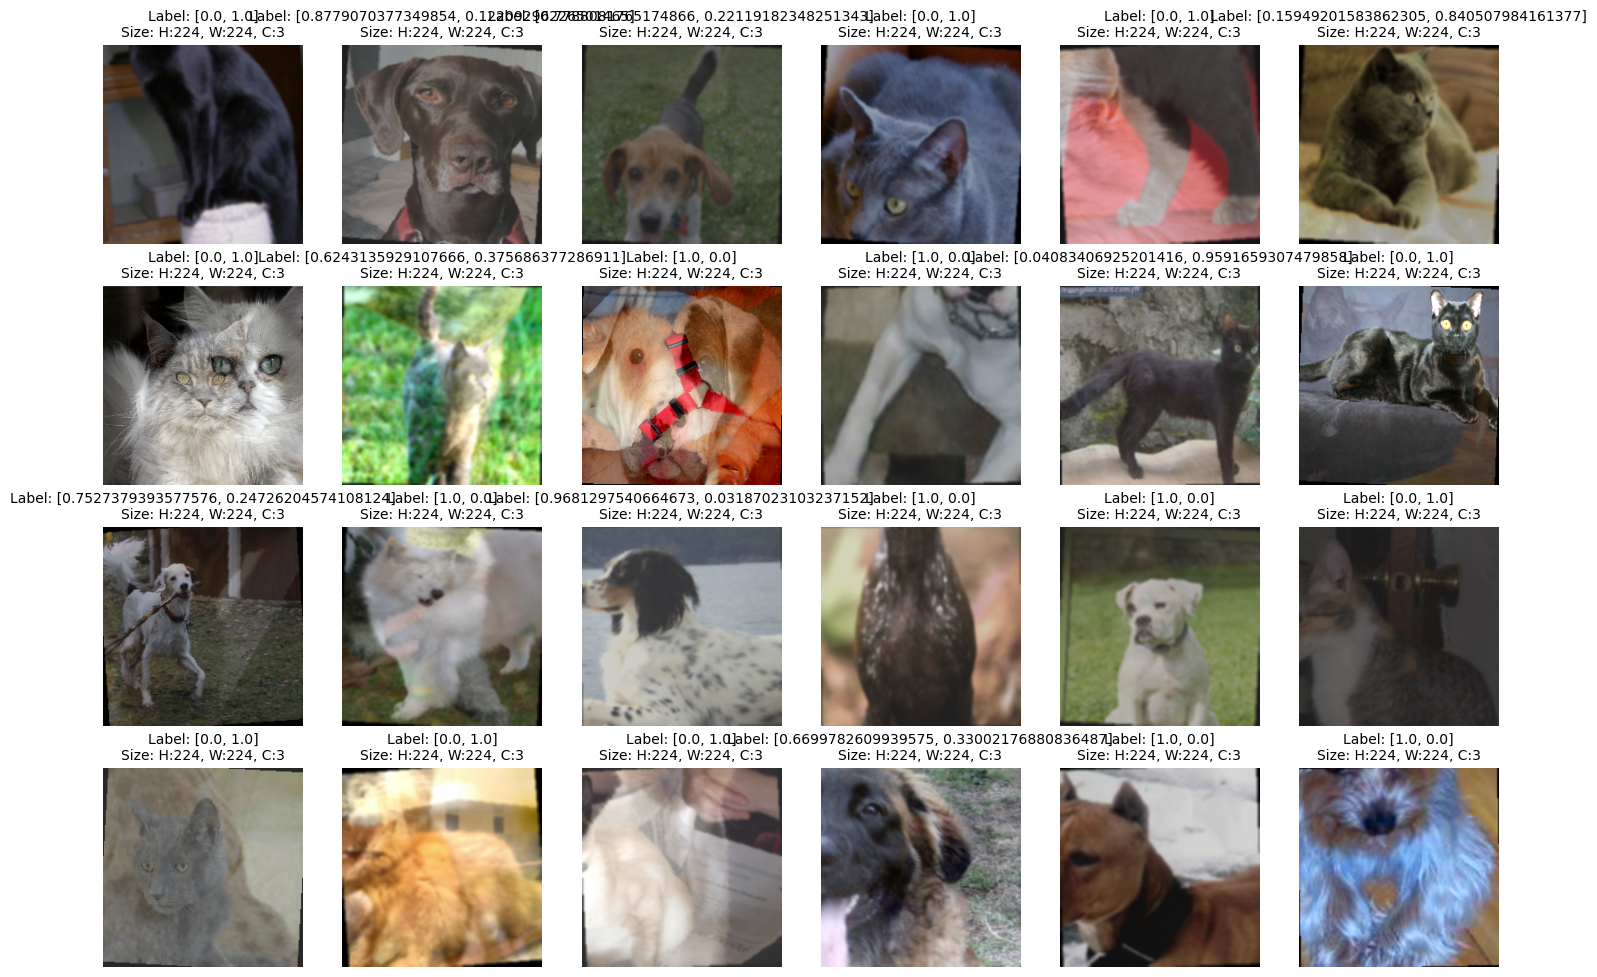

In [10]:

data_augmentation =   [   
                        #{'type': 'cutmix', 'alpha': 300, 'prob': 0.2, 'beta': 1.0, 'num_classes': 2, 'train': True, 'eval': False},
                        {'type': 'mixup', 'alpha': 1.0, 'prob': 0.5, 'beta': 1.0, 'num_classes': 2, 'train': True, 'eval': False},
                        {'type': 'random_rotation','degrees': 5, 'train': True, 'eval': False},
                        {'type': 'random_horizontal_flip','prob': 0.3, 'train': True, 'eval': False},
                        {'type': 'color_jitter', 'brightness': 0.4, 'contrast': 0.4, 'saturation': 0.3, 'hue': 0.0, 'train': True, 'eval': False},
                        {'type': 'gaussian_blur', 'kernel_size':(5,5), 'sigma': (0.1,2.0), 'train': True, 'eval': False},
                    ]



data_augmentor = tg.data.ImageDataAugmentor(data_augmentation)
tg.visualization.visualize_dataloader(train_augmentation_dataset, data_augmentor=data_augmentor, layout=(4,6))


## Logging
In the following we will use a logger from our package that logs all defined metrics internalls and to TensorBoard. 
The source code of the logger is provided below.



In [11]:
tBoard_base_log_dir = os.path.join(os.getcwd(), 'data/tensorboard_logs')
if not os.path.exists(tBoard_base_log_dir):
    os.makedirs(tBoard_base_log_dir)

tBoard_log_dir = {}

exp_names = ['resnet', 'resnet_noag', 'vgg', 'vgg_noag', 'mobilenet','mobilenet_noag', 'resnet_finetune', 'resnet_freeze', 'resnet_combined']

for exp_name in exp_names:
    tBoard_log_dir[exp_name] = os.path.join(tBoard_base_log_dir, exp_name)
    if not os.path.exists(tBoard_log_dir[exp_name]):
        os.makedirs(tBoard_log_dir[exp_name])
    





### Logger Implementation 

```python

class _Logger():
    def __init__(self,
                save_dir = None,
                    log_name: str = None,
                        model_config: dict = None,
                            writer: SummaryWriter = None,
                            save_external: bool = True,                                    
                            save_internal: bool = False, 
                                ):
        """
            The module logs the data internally to be accessed later or externally to the disk using TensorBoard.
            It can be simply implemented in the training pipeline to handle all logging tasks.

            Arguments:
                save_dir (str): The path to save tensorboard logs.
                log_name (str): The suffix of the name of the log.
                model_config (dict): The configuration of the model.
                writer (SummaryWriter): The tensorboard writer. If None and save_external, a new SummaryWriter is created
                save_external (bool): Whether to save the logs externally to TensorBoard
                save_internal (bool): Whether to save the logs internally in a dictionary.
        """ 
        # Save directory
        self.save_dir = save_dir
        
        ### Run Information ###
        self.log_name = log_name
        self.writer = writer
        # Enable logging to TensorBoard
        if save_external:
            assert save_dir is not None or self.writer is not None, "Path to save tensorboard logs has to be specified..."
            if self.writer is None:
                self.writer = SummaryWriter(log_dir=self.save_dir) if log_name is None else SummaryWriter(log_dir=self.save_dir, filename_suffix=log_name)

        self.model_config = model_config

        self.save_internal = save_internal
        self.save_external = save_external
        self._internal_log = {}

        self.log_gradients = False

        
        
    def log_data(self, epoch: int, data: dict,  iteration: int=None):
        """
            Log the data.
            Arguments:
                epoch (int): The current epoch. 
                data (dict): The data to log.
                    Format:
                            {
                                [name]: value,
                                ...
                            }
        
        """
        # Save on disk using TensorBoard
        if self.save_external:
            for key, value in data.items():
                # If we get a nested list but the the nested list contains only a single element we simply unpack this element.
                if type(value) == list and len(value) == 1:
                    value = value[0]
                # If we have a list of values as a value in the data dictionary, we assume this comes from a metric logged iteration-wise
                # We distringuish between metrics logged epoch-wise and iteration-wise when saved with TensorBoard
                if type(value) == list:
                    prefix_name = f'iteration_metrics/'
                    log_iter = self.model_config['num_iterations']*(epoch-1)
                    for i, item in enumerate(value):
                        self.writer.add_scalar(prefix_name + key, item, log_iter + i +1)
                    continue
                # Set prefix to log the metric either epoch-wise or iteration-wise
                prefix_name = f'epoch_metrics/' if iteration is None else f'iteration_metrics/'
                log_iter = epoch if iteration is None else (self.model_config['num_iterations']*(epoch-1) + iteration)
                # Write to TensorBoard
                self.writer.add_scalar(prefix_name + key, value, log_iter)
            
        if self.save_internal:
            self._save_internal(data)
    
    def get_log(self):
        """
            Get all logs that were saved internally.
        """
        return self._internal_log

    def get_last_log(self):
        """
            Get the last entry for all internally logger metrics.
        """
        last_log = {}
        for key in self._internal_log.keys():
            last_log[key] = self._internal_log[key][-1]
        return last_log

    def enable_internal_log(self):
        self.save_internal = True
    
    def disable_internal_log(self):
        self.save_internal = False

    
    def _save_internal(self, data):
        """
            Save the data internally in the internal log dictionary. The values can be retrieved later when needed
        """
        for key, value in data.items():
            if not key in self._internal_log.keys():
                self._internal_log[key] = []
            if type(value) == list:
                self._internal_log[key] += value
                continue
            self._internal_log[key].append(value)
```

## Task 1: Comparison ResNet, VGG, MobileNetV3

### ResNet-18

In [12]:
EXP_EPOCHS = 16


# ## Task 1: Comparison ResNet, VGG and MobileNetV3

# ## ResNet-18

data_augmentation =   [   
                        #{'type': 'cutmix', 'alpha': 300, 'prob': 0.2, 'beta': 1.0, 'num_classes': 2, 'train': True, 'eval': False},
                        {'type': 'mixup', 'alpha': 1.0, 'prob': 0.5, 'beta': 1.0, 'num_classes': 2, 'train': True, 'eval': False},
                        {'type': 'random_rotation','degrees': 5, 'train': True, 'eval': False},
                        {'type': 'random_horizontal_flip','prob': 0.3, 'train': True, 'eval': False},
                        {'type': 'color_jitter', 'brightness': 0.4, 'contrast': 0.4, 'saturation': 0.3, 'hue': 0.0, 'train': True, 'eval': False},
                        {'type': 'gaussian_blur', 'kernel_size':(5,5), 'sigma': (0.1,2.0), 'train': True, 'eval': False},
                        {'type': 'normalize', 'train': True, 'eval': True},
                    ]

RESNET_MODEL_ARCHITECTURE =     [
                                    {'type': 'ResNet', 'size': 18, 'remove_layer': 1, 'weights': 'DEFAULT'},
                                    {'type': 'flatten'},
                                    {'type': 'dropout', 'prob': 0.3},
                                    {'type': 'linear', 'in_features': tg.models.RESNET_FEATURE_DIM[18][1], 'out_features': 2}
                                ]


RESNET_MODEL_CONFIG =  {
                            'layers': RESNET_MODEL_ARCHITECTURE,
                            'output_dim': 2,
                            'activation': 'relu',
                            'batch_size': 32,
                            'num_epochs': EXP_EPOCHS,
                            'num_iterations': 0,
                            'learning_rate': 0.00003,
                            'random_seed': 22,
                            'pre_processing': data_augmentation,
                            'evaluation': {
                                'metrics': ['accuracy'],
                                'frequency': 1
                            },
                            'dataset': {
                                    'name': 'oxfordpets',
                                    'train_size': 2000,
                                    'val_size': 0,
                                    'test_size': 3669,
                                    'train_shuffle': True,
                                    'eval_shuffle': False,
                                    'drop_last': True,
                                    'classes': [0, 1]
                            },
                            'scheduler': {'epoch_scheduler': {'type': 'exponential', 'gamma': 0.9}, 'iteration_scheduler': None},
                            'optimizer': {'type': 'Adam'}
                            
                        }
RESNET_MODEL_CONFIG['num_iterations'] = tg.training.get_num_iterations(RESNET_MODEL_CONFIG)

RESNET_MODEL_CONFIG_NO_AUGM =  {
                            'layers': RESNET_MODEL_ARCHITECTURE,
                            'output_dim': 2,
                            'activation': 'relu',
                            'batch_size': 32,
                            'num_epochs': EXP_EPOCHS,
                            'num_iterations': 0,
                            'learning_rate': 0.00003,
                            'random_seed': 22,
                            'pre_processing': [],
                            'evaluation': {
                                'metrics': ['accuracy'],
                                'frequency': 1
                            },
                            'dataset': {
                                    'name': 'oxfordpets',
                                    'train_size': 2000,
                                    'val_size': 0,
                                    'test_size': 3669,
                                    'train_shuffle': True,
                                    'eval_shuffle': False,
                                    'drop_last': True,
                                    'classes': [0, 1]
                            },
                            'scheduler': {'epoch_scheduler': {'type': 'exponential', 'gamma': 0.9}, 'iteration_scheduler': None},
                            'optimizer': {'type': 'Adam'}
                            
                        }
RESNET_MODEL_CONFIG_NO_AUGM['num_iterations'] = tg.training.get_num_iterations(RESNET_MODEL_CONFIG_NO_AUGM)



#### Baseline (Without Data Augmentation)

In [13]:
tBoard_log_dir.keys()

dict_keys(['resnet', 'resnet_noag', 'vgg', 'vgg_noag', 'mobilenet', 'mobilenet_noag', 'resnet_finetune', 'resnet_freeze', 'resnet_combined'])

In [14]:
train_loader = torch.utils.data.DataLoader(train_augmentation_dataset, batch_size=RESNET_MODEL_CONFIG_NO_AUGM['batch_size'], shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_augmentation_dataset, batch_size=RESNET_MODEL_CONFIG_NO_AUGM['batch_size'], shuffle=False, drop_last=True)


resnet_noag_logger = tg.logging.Logger(save_dir=tBoard_log_dir['resnet_noag'], model_config = RESNET_MODEL_CONFIG_NO_AUGM, save_external=True, save_internal=True)

resnet_noag_model, resnet_noag_train_loader, resnet_noag_test_loader, resnet_noag_data_augmentor, resnet_noag_logger = tg.training.trainNN(config=RESNET_MODEL_CONFIG_NO_AUGM, train_loader=train_loader, test_loader=test_loader, logger=resnet_noag_logger)

Initial Evluation


Evaluation:: 100%|██████████| 114/114 [00:07<00:00, 15.40it/s]


 accuracy: 0.5386513157894737, eval_loss: 0.7269827394109023,

Epoch 1/16


Evaluation:: 100%|██████████| 114/114 [00:07<00:00, 14.90it/s]


accuracy: 0.9846491228070176, eval_loss: 0.07353477293151643, train_loss: 0.1920423060655594

Epoch 2/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 14.19it/s]


accuracy: 0.9865679824561403, eval_loss: 0.049948126945660955, train_loss: 0.45512568950653076

Epoch 3/16


Evaluation:: 100%|██████████| 114/114 [00:11<00:00, 10.18it/s]


accuracy: 0.9893092105263158, eval_loss: 0.04129925453851588, train_loss: 0.04449744522571564

Epoch 4/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 13.87it/s]


accuracy: 0.9895833333333334, eval_loss: 0.03180698715783492, train_loss: 0.08429422974586487

Epoch 5/16


Evaluation:: 100%|██████████| 114/114 [00:10<00:00, 11.35it/s]


accuracy: 0.9906798245614035, eval_loss: 0.0275546481997273, train_loss: 0.019941389560699463

Epoch 6/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.87it/s]


accuracy: 0.9898574561403509, eval_loss: 0.028938126253993494, train_loss: 0.07769057154655457

Epoch 7/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 13.66it/s]


accuracy: 0.9920504385964912, eval_loss: 0.02226280279839493, train_loss: 0.06921293586492538

Epoch 8/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 13.45it/s]


accuracy: 0.9923245614035088, eval_loss: 0.02333382111841306, train_loss: 0.043804094195365906

Epoch 9/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 13.21it/s]


accuracy: 0.993421052631579, eval_loss: 0.022229986831549916, train_loss: 0.08328738063573837

Epoch 10/16


Evaluation:: 100%|██████████| 114/114 [00:11<00:00,  9.59it/s]


accuracy: 0.9923245614035088, eval_loss: 0.020806792456648526, train_loss: 0.12471796572208405

Epoch 11/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.95it/s]


accuracy: 0.9931469298245614, eval_loss: 0.0212378453523566, train_loss: 0.07900167256593704

Epoch 12/16


Evaluation:: 100%|██████████| 114/114 [00:11<00:00, 10.13it/s]


accuracy: 0.9923245614035088, eval_loss: 0.022522981058277207, train_loss: 0.03573008254170418

Epoch 13/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 13.31it/s]


accuracy: 0.9928728070175439, eval_loss: 0.020997184439916612, train_loss: 0.03818480670452118

Epoch 14/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 11.80it/s]


accuracy: 0.9939692982456141, eval_loss: 0.01916218239644526, train_loss: 0.03741271793842316

Epoch 15/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.43it/s]


accuracy: 0.9936951754385965, eval_loss: 0.019700817934343626, train_loss: 0.06674008071422577

Epoch 16/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 13.29it/s]

accuracy: 0.9931469298245614, eval_loss: 0.02140599151977783, train_loss: 0.06938420236110687


#### Training with Data Augmentation

In [15]:

train_loader = torch.utils.data.DataLoader(train_augmentation_dataset, batch_size=RESNET_MODEL_CONFIG['batch_size'], shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_augmentation_dataset, batch_size=RESNET_MODEL_CONFIG['batch_size'], shuffle=False, drop_last=True)

resnet_logger = tg.logging.Logger(save_dir=tBoard_log_dir['resnet'], model_config = RESNET_MODEL_CONFIG, save_external=True, save_internal=True)

resnet_model, resnet_train_loader, resnet_test_loader, resnet_data_augmentor, resnet_logger = tg.training.trainNN(config=RESNET_MODEL_CONFIG, train_loader=train_loader, test_loader=test_loader, logger = resnet_logger)


Initial Evluation


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 13.17it/s]


 accuracy: 0.6096491228070176, eval_loss: 0.727478292296853,

Epoch 1/16


Evaluation:: 100%|██████████| 114/114 [00:10<00:00, 10.46it/s]


accuracy: 0.9443530701754386, eval_loss: 0.20573352133495765, train_loss: 0.49386605620384216

Epoch 2/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 13.12it/s]


accuracy: 0.9638157894736842, eval_loss: 0.16273457155023752, train_loss: 0.5467692017555237

Epoch 3/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 13.16it/s]


accuracy: 0.9788925438596491, eval_loss: 0.14460463312111402, train_loss: 0.5079086422920227

Epoch 4/16


Evaluation:: 100%|██████████| 114/114 [00:11<00:00,  9.90it/s]


accuracy: 0.9766995614035088, eval_loss: 0.16071019808582046, train_loss: 0.3505183458328247

Epoch 5/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.87it/s]


accuracy: 0.9810855263157895, eval_loss: 0.14438204699310295, train_loss: 0.3097870647907257

Epoch 6/16


Evaluation:: 100%|██████████| 114/114 [00:10<00:00, 10.67it/s]


accuracy: 0.981359649122807, eval_loss: 0.15165814077645018, train_loss: 0.3346632719039917

Epoch 7/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.88it/s]


accuracy: 0.9832785087719298, eval_loss: 0.1552628192789199, train_loss: 0.6121822595596313

Epoch 8/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.69it/s]


accuracy: 0.9797149122807017, eval_loss: 0.1572564666143112, train_loss: 0.31282371282577515

Epoch 9/16


Evaluation:: 100%|██████████| 114/114 [00:11<00:00,  9.98it/s]


accuracy: 0.9731359649122807, eval_loss: 0.17312534767807575, train_loss: 0.37957146763801575

Epoch 10/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.81it/s]


accuracy: 0.977796052631579, eval_loss: 0.1576377172023058, train_loss: 0.4417164921760559

Epoch 11/16


Evaluation:: 100%|██████████| 114/114 [00:11<00:00,  9.77it/s]


accuracy: 0.9871162280701754, eval_loss: 0.1275462574537909, train_loss: 0.42463570833206177

Epoch 12/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.81it/s]


accuracy: 0.9851973684210527, eval_loss: 0.143763756640909, train_loss: 0.1889699101448059

Epoch 13/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 13.26it/s]


accuracy: 0.9758771929824561, eval_loss: 0.1740107928124959, train_loss: 0.49973440170288086

Epoch 14/16


Evaluation:: 100%|██████████| 114/114 [00:10<00:00, 11.06it/s]


accuracy: 0.9857456140350878, eval_loss: 0.13438560937841734, train_loss: 0.4776380956172943

Epoch 15/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.36it/s]


accuracy: 0.9895833333333334, eval_loss: 0.1259157548478821, train_loss: 0.43600994348526

Epoch 16/16


Evaluation:: 100%|██████████| 114/114 [00:11<00:00, 10.27it/s]

accuracy: 0.9871162280701754, eval_loss: 0.13488054314726278, train_loss: 0.41916507482528687


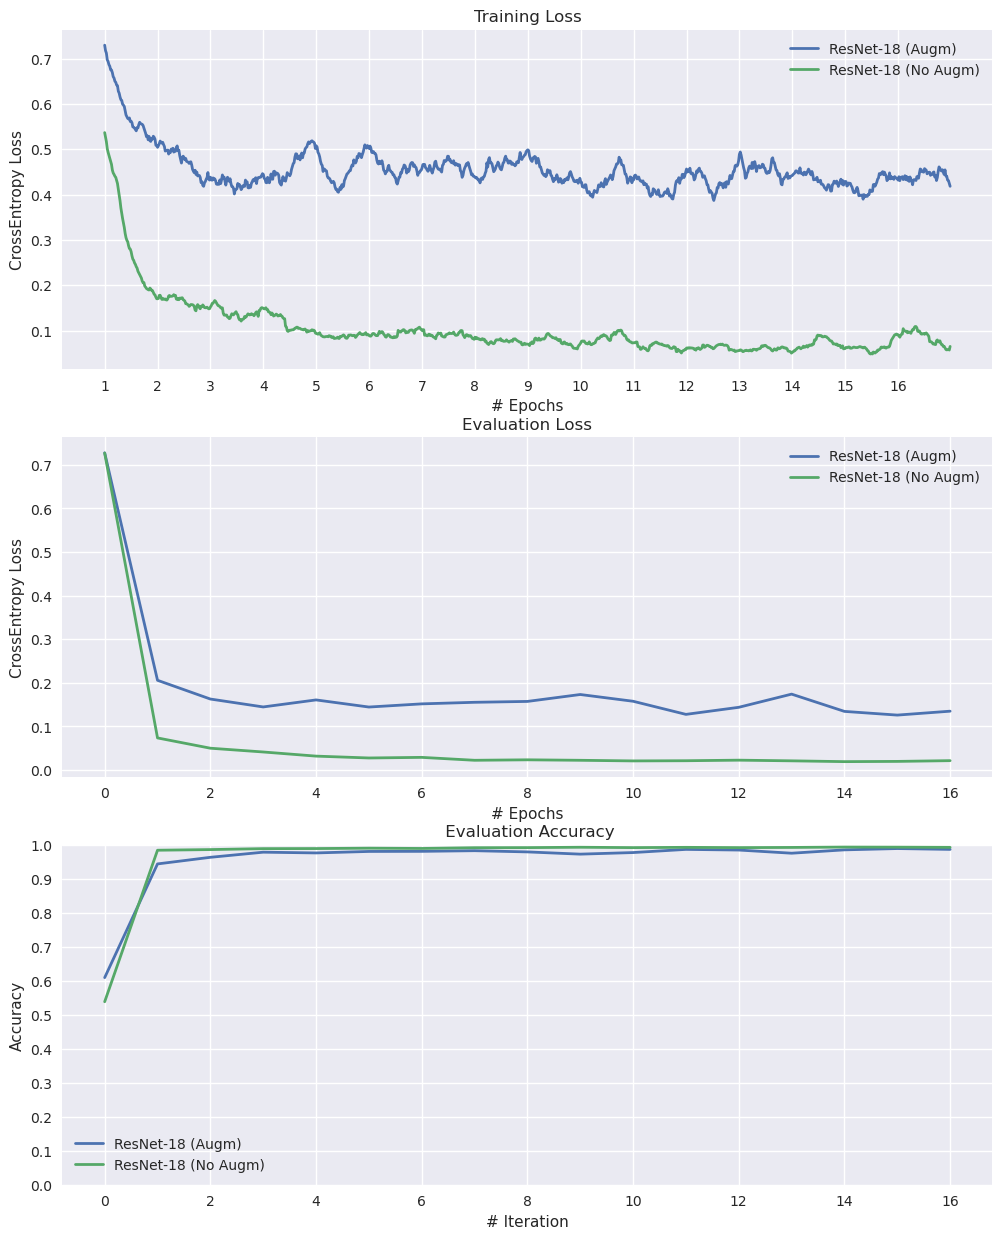

In [16]:
def compare_training_results(logger_list: list, model_names: list, config: dict):
    assert len(logger_list)==len(model_names), f'Length of logger list {len(logger_list)} does not correspond to the length of the mode list {len(model_names)}'
    #iteration_corrected = [np.sum(np.arange(i)*config['num_iterations']) for i in range(config['num_epochs']+1)]
    xticks = range(0, config['num_epochs']*config['num_iterations'], config['num_iterations'])
    plt.style.use('seaborn-v0_8')
    # Load the data from the MLP training
    data = []
    train_loss = []
    eval_loss = []
    eval_acc = []
    for logger in logger_list:
        data = logger.get_log()
        train_loss.append(data['train_loss'])
        eval_loss.append(data['eval_loss'])
        eval_acc.append(data['accuracy'])
    fig = plt.figure(figsize=(12,15))

    ax1 = fig.add_subplot(311)
    for i in range(len(logger_list)):
        smooth_loss = tg.visualization.smooth_curve(train_loss[i], 31)
        ax1.plot(smooth_loss, label=model_names[i], linewidth=2)

    ax1.set_xlabel("# Epochs")
    ax1.set_xticks(xticks, np.arange(1, config['num_epochs']+1))
    ax1.set_ylabel("CrossEntropy Loss")
    ax1.set_title('Training Loss')
    ax1.legend()

    ax2 = fig.add_subplot(312)
    for i in range(len(logger_list)):
        ax2.plot(eval_loss[i], label=model_names[i], linewidth=2)

    ax2.set_xlabel("# Epochs")
    ax2.set_ylabel("CrossEntropy Loss")
    ax2.set_title('Evaluation Loss')
    ax2.legend()

    ax3 = fig.add_subplot(313)
    for i in range(len(logger_list)):
        ax3.plot(eval_acc[i], label=model_names[i], linewidth=2)

    ax3.set_ylim(0.0,1.0)
    ax3.set_yticks(np.arange(0.0, 1.1, 0.1).tolist())
    ax3.set_xlabel("# Iteration")
    ax3.set_ylabel("Accuracy")
    ax3.set_title(' Evaluation Accuracy')
    ax3.legend()

    return fig

fig = compare_training_results([resnet_logger, resnet_noag_logger], ['ResNet-18 (Augm)', 'ResNet-18 (No Augm)'], RESNET_MODEL_CONFIG)

### VGG-11

In [17]:
VGG_MODEL_ARCHITECTURE =     [
                                    {'type': 'VGG', 'size': 11, 'remove_layer': 1, 'weights': 'DEFAULT'},
                                    {'type': 'flatten'},
                                    {'type': 'dropout', 'prob': 0.3},
                                    {'type': 'linear', 'in_features': 25088, 'out_features': 4608},
                                    {'type': 'batchnorm1d', 'num_features': 4608, 'eps':1e-05, 'momentum': 0.1},
                                    {'type': 'relu'},
                                    {'type': 'linear', 'in_features': 4608, 'out_features': 256},
                                    {'type': 'batchnorm1d', 'num_features': 256, 'eps':1e-05, 'momentum': 0.1},
                                    {'type': 'relu'},
                                    {'type': 'linear', 'in_features': 256, 'out_features': 2},
                                ]


VGG_MODEL_CONFIG =  {
                            'layers': VGG_MODEL_ARCHITECTURE,
                            'output_dim': 2,
                            'activation': 'relu',
                            'batch_size': 32,
                            'num_epochs': EXP_EPOCHS,
                            'num_iterations': 0,
                            'learning_rate': 0.00003,
                            'random_seed': 22,
                            'pre_processing': data_augmentation,
                            'evaluation': {
                                'metrics': ['accuracy'],
                                'frequency': 1
                            },
                            'dataset': {
                                    'name': 'oxfordpets',
                                    'train_size': 2000,
                                    'val_size': 0,
                                    'test_size': 3669,
                                    'train_shuffle': True,
                                    'eval_shuffle': False,
                                    'drop_last': True,
                                    'classes': [0, 1]
                            },
                            'scheduler': {'epoch_scheduler': {'type': 'exponential', 'gamma': 0.9}, 'iteration_scheduler': None},
                            'optimizer': {'type': 'Adam'}
                            
                        }

VGG_MODEL_CONFIG_NO_AUGM =  {
                            'layers': VGG_MODEL_ARCHITECTURE,
                            'output_dim': 2,
                            'activation': 'relu',
                            'batch_size': 32,
                            'num_epochs': EXP_EPOCHS,
                            'num_iterations': 0,
                            'learning_rate': 0.00003,
                            'random_seed': 22,
                            'pre_processing': [],
                            'evaluation': {
                                'metrics': ['accuracy'],
                                'frequency': 1
                            },
                            'dataset': {
                                    'name': 'oxfordpets',
                                    'train_size': 2000,
                                    'val_size': 0,
                                    'test_size': 3669,
                                    'train_shuffle': True,
                                    'eval_shuffle': False,
                                    'drop_last': True,
                                    'classes': [0, 1]
                            },
                            'scheduler': {'epoch_scheduler': {'type': 'exponential', 'gamma': 0.9}, 'iteration_scheduler': None},
                            'optimizer': {'type': 'Adam'}
                            
                        }

#### Baseline (Without Data Augmentation)

In [18]:
train_loader = torch.utils.data.DataLoader(train_augmentation_dataset, batch_size=VGG_MODEL_CONFIG_NO_AUGM['batch_size'], shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_augmentation_dataset, batch_size=VGG_MODEL_CONFIG_NO_AUGM['batch_size'], shuffle=False, drop_last=True)

vgg_noag_logger = tg.logging.Logger(save_dir=tBoard_log_dir['vgg_noag'], model_config = VGG_MODEL_CONFIG_NO_AUGM, save_external=True, save_internal=True)

vgg_noag_model, vgg_noag_train_loader, vgg_noag_test_loader, vgg_noag_data_augmentor, vgg_noag_logger = tg.training.trainNN(config=VGG_MODEL_CONFIG_NO_AUGM, logger=vgg_noag_logger, train_loader=train_loader, test_loader=test_loader)

Initial Evluation


Evaluation:: 100%|██████████| 114/114 [00:14<00:00,  7.77it/s]


 accuracy: 0.6655701754385965, eval_loss: 0.668333487552509,

Epoch 1/16


Evaluation:: 100%|██████████| 114/114 [00:15<00:00,  7.50it/s]


accuracy: 0.975328947368421, eval_loss: 0.08380336600576381, train_loss: 0.26134192943573

Epoch 2/16


Evaluation:: 100%|██████████| 114/114 [00:15<00:00,  7.35it/s]


accuracy: 0.9788925438596491, eval_loss: 0.0711551375095855, train_loss: 0.12288546562194824

Epoch 3/16


Evaluation:: 100%|██████████| 114/114 [00:16<00:00,  6.71it/s]


accuracy: 0.9783442982456141, eval_loss: 0.06547917736788166, train_loss: 0.16253727674484253

Epoch 4/16


Evaluation:: 100%|██████████| 114/114 [00:16<00:00,  6.77it/s]


accuracy: 0.9791666666666666, eval_loss: 0.07390094230670416, train_loss: 0.19288113713264465

Epoch 5/16


Evaluation:: 100%|██████████| 114/114 [00:15<00:00,  7.16it/s]


accuracy: 0.9797149122807017, eval_loss: 0.06977987966679952, train_loss: 0.1568089723587036

Epoch 6/16


Evaluation:: 100%|██████████| 114/114 [00:15<00:00,  7.50it/s]


accuracy: 0.9816337719298246, eval_loss: 0.06244518579976437, train_loss: 0.08808521181344986

Epoch 7/16


Evaluation:: 100%|██████████| 114/114 [00:15<00:00,  7.57it/s]


accuracy: 0.9838267543859649, eval_loss: 0.052106049267183006, train_loss: 0.10367107391357422

Epoch 8/16


Evaluation:: 100%|██████████| 114/114 [00:16<00:00,  6.73it/s]


accuracy: 0.9766995614035088, eval_loss: 0.0727583880846699, train_loss: 0.030411813408136368

Epoch 9/16


Evaluation:: 100%|██████████| 114/114 [00:16<00:00,  6.82it/s]


accuracy: 0.9851973684210527, eval_loss: 0.04733270032764331, train_loss: 0.17542937397956848

Epoch 10/16


Evaluation:: 100%|██████████| 114/114 [00:16<00:00,  6.91it/s]


accuracy: 0.9824561403508771, eval_loss: 0.05599560265290437, train_loss: 0.14453017711639404

Epoch 11/16


Evaluation:: 100%|██████████| 114/114 [00:16<00:00,  7.10it/s]


accuracy: 0.9824561403508771, eval_loss: 0.06116137556780718, train_loss: 0.08353561908006668

Epoch 12/16


Evaluation:: 100%|██████████| 114/114 [00:14<00:00,  7.64it/s]


accuracy: 0.9854714912280702, eval_loss: 0.047990618784209356, train_loss: 0.05999280512332916

Epoch 13/16


Evaluation:: 100%|██████████| 114/114 [00:14<00:00,  7.70it/s]


accuracy: 0.9838267543859649, eval_loss: 0.05024038704639105, train_loss: 0.11099214106798172

Epoch 14/16


Evaluation:: 100%|██████████| 114/114 [00:16<00:00,  6.77it/s]


accuracy: 0.9838267543859649, eval_loss: 0.048988411276552235, train_loss: 0.04320163279771805

Epoch 15/16


Evaluation:: 100%|██████████| 114/114 [00:16<00:00,  6.92it/s]


accuracy: 0.9849232456140351, eval_loss: 0.045749249165518244, train_loss: 0.0908660963177681

Epoch 16/16


Evaluation:: 100%|██████████| 114/114 [00:16<00:00,  6.99it/s]

accuracy: 0.9821820175438597, eval_loss: 0.05355925181586491, train_loss: 0.10089810937643051


#### Training with Data Augmentation

In [19]:
train_loader = torch.utils.data.DataLoader(train_augmentation_dataset, batch_size=VGG_MODEL_CONFIG['batch_size'], shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_augmentation_dataset, batch_size=VGG_MODEL_CONFIG['batch_size'], shuffle=False, drop_last=True)

vgg_logger = tg.logging.Logger(save_dir=tBoard_log_dir['vgg'], model_config = VGG_MODEL_CONFIG, save_external=True, save_internal=True)

vgg_model, vgg_train_loader, vgg_test_loader, vgg_data_augmentor, vgg_logger = tg.training.trainNN(config=VGG_MODEL_CONFIG, logger=vgg_logger, train_loader=train_loader, test_loader=test_loader)

Initial Evluation


Evaluation:: 100%|██████████| 114/114 [00:16<00:00,  6.75it/s]


 accuracy: 0.47286184210526316, eval_loss: 0.7044379606581571,

Epoch 1/16


Evaluation:: 100%|██████████| 114/114 [00:16<00:00,  6.91it/s]


accuracy: 0.9701206140350878, eval_loss: 0.1352609597277223, train_loss: 0.4886717200279236

Epoch 2/16


Evaluation:: 100%|██████████| 114/114 [00:16<00:00,  6.92it/s]


accuracy: 0.9739583333333334, eval_loss: 0.11056876043674715, train_loss: 0.4970216453075409

Epoch 3/16


Evaluation:: 100%|██████████| 114/114 [00:16<00:00,  7.08it/s]


accuracy: 0.9734100877192983, eval_loss: 0.10977473622187972, train_loss: 0.4870920777320862

Epoch 4/16


Evaluation:: 100%|██████████| 114/114 [00:15<00:00,  7.58it/s]


accuracy: 0.9462719298245614, eval_loss: 0.18579790965049414, train_loss: 0.32033637166023254

Epoch 5/16


Evaluation:: 100%|██████████| 114/114 [00:15<00:00,  7.36it/s]


accuracy: 0.9827302631578947, eval_loss: 0.1155031201707428, train_loss: 0.5857908725738525

Epoch 6/16


Evaluation:: 100%|██████████| 114/114 [00:16<00:00,  6.94it/s]


accuracy: 0.9788925438596491, eval_loss: 0.10614991057337377, train_loss: 0.3895891606807709

Epoch 7/16


Evaluation:: 100%|██████████| 114/114 [00:16<00:00,  6.81it/s]


accuracy: 0.9846491228070176, eval_loss: 0.10566563946766812, train_loss: 0.6563842296600342

Epoch 8/16


Evaluation:: 100%|██████████| 114/114 [00:16<00:00,  7.06it/s]


accuracy: 0.9841008771929824, eval_loss: 0.11473051262529273, train_loss: 0.38213592767715454

Epoch 9/16


Evaluation:: 100%|██████████| 114/114 [00:15<00:00,  7.47it/s]


accuracy: 0.9797149122807017, eval_loss: 0.11140855406656076, train_loss: 0.5788290500640869

Epoch 10/16


Evaluation:: 100%|██████████| 114/114 [00:15<00:00,  7.44it/s]


accuracy: 0.9841008771929824, eval_loss: 0.10883882529053249, train_loss: 0.1836499571800232

Epoch 11/16


Evaluation:: 100%|██████████| 114/114 [00:17<00:00,  6.60it/s]


accuracy: 0.9879385964912281, eval_loss: 0.09652846600664289, train_loss: 0.36816367506980896

Epoch 12/16


Evaluation:: 100%|██████████| 114/114 [00:16<00:00,  6.88it/s]


accuracy: 0.9890350877192983, eval_loss: 0.10954939015209675, train_loss: 0.47102630138397217

Epoch 13/16


Evaluation:: 100%|██████████| 114/114 [00:16<00:00,  7.09it/s]


accuracy: 0.9904057017543859, eval_loss: 0.09287278609056222, train_loss: 0.3818756341934204

Epoch 14/16


Evaluation:: 100%|██████████| 114/114 [00:15<00:00,  7.40it/s]


accuracy: 0.9871162280701754, eval_loss: 0.1195999286545996, train_loss: 0.41253647208213806

Epoch 15/16


Evaluation:: 100%|██████████| 114/114 [00:16<00:00,  6.98it/s]


accuracy: 0.9893092105263158, eval_loss: 0.10093510199926402, train_loss: 0.3796873688697815

Epoch 16/16


Evaluation:: 100%|██████████| 114/114 [00:16<00:00,  6.72it/s]

accuracy: 0.9865679824561403, eval_loss: 0.10193649385320513, train_loss: 0.4539961516857147


### MobileNet-V3

In [20]:
MOBILENET_MODEL_ARCHITECTURE =     [
                                    {'type': 'MobileNetV3', 'size': 'small', 'remove_layer': 1, 'weights': 'DEFAULT'},
                                    {'type': 'flatten'},
                                    {'type': 'dropout', 'prob': 0.3},
                                    {'type': 'linear', 'in_features': 576, 'out_features': 2}
                                ]



MOBILENET_MODEL_CONFIG =  {
                            'layers': RESNET_MODEL_ARCHITECTURE,
                            'output_dim': 2,
                            'activation': 'relu',
                            'batch_size': 32,
                            'num_epochs': EXP_EPOCHS,
                            'num_iterations': 0,
                            'learning_rate': 0.00003,
                            'random_seed': 22,
                            'pre_processing': data_augmentation,
                            'evaluation': {
                                'metrics': ['accuracy'],
                                'frequency': 1
                            },
                            'dataset': {
                                    'name': 'oxfordpets',
                                    'train_size': 2000,
                                    'val_size': 0,
                                    'test_size': 3669,
                                    'train_shuffle': True,
                                    'eval_shuffle': False,
                                    'drop_last': True,
                                    'classes': [0, 1]
                            },
                            'scheduler': {'epoch_scheduler': {'type': 'exponential', 'gamma': 0.9}, 'iteration_scheduler': None},
                            'optimizer': {'type': 'Adam'}
                            
                        }

MOBILENET_MODEL_CONFIG_NO_AUGM =  {
                            'layers': RESNET_MODEL_ARCHITECTURE,
                            'output_dim': 2,
                            'activation': 'relu',
                            'batch_size': 32,
                            'num_epochs': EXP_EPOCHS,
                            'num_iterations': 0,
                            'learning_rate': 0.00003,
                            'random_seed': 22,
                            'pre_processing': [],
                            'evaluation': {
                                'metrics': ['accuracy'],
                                'frequency': 1
                            },
                            'dataset': {
                                    'name': 'oxfordpets',
                                    'train_size': 2000,
                                    'val_size': 0,
                                    'test_size': 3669,
                                    'train_shuffle': True,
                                    'eval_shuffle': False,
                                    'drop_last': True,
                                    'classes': [0, 1]
                            },
                            'scheduler': {'epoch_scheduler': {'type': 'exponential', 'gamma': 0.9}, 'iteration_scheduler': None},
                            'optimizer': {'type': 'Adam'}
                            
                        }

#### Baseline (Without Data Augmentation)

In [21]:
train_loader = torch.utils.data.DataLoader(train_augmentation_dataset, batch_size=MOBILENET_MODEL_CONFIG_NO_AUGM['batch_size'], shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_augmentation_dataset, batch_size=MOBILENET_MODEL_CONFIG_NO_AUGM['batch_size'], shuffle=False, drop_last=True)

mbnet_noag_logger = tg.logging.Logger(save_dir=tBoard_log_dir['mobilenet_noag'], model_config = MOBILENET_MODEL_CONFIG_NO_AUGM, save_external=True, save_internal=True)

mbnet_noag_model, mbnet_noag_train_loader, mbnet_noag_test_loader, mbnet_noag_data_augmentor, mbnet_noag_logger = tg.training.trainNN(config=MOBILENET_MODEL_CONFIG_NO_AUGM, logger=mbnet_noag_logger, train_loader=train_loader, test_loader=test_loader)

Initial Evluation


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 13.17it/s]


 accuracy: 0.4133771929824561, eval_loss: 0.8561291686798397,

Epoch 1/16


Evaluation:: 100%|██████████| 114/114 [00:10<00:00, 10.40it/s]


accuracy: 0.9838267543859649, eval_loss: 0.08234637218788919, train_loss: 0.16966107487678528

Epoch 2/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.80it/s]


accuracy: 0.9895833333333334, eval_loss: 0.047780843125860485, train_loss: 0.08088445663452148

Epoch 3/16


Evaluation:: 100%|██████████| 114/114 [00:14<00:00,  8.00it/s]


accuracy: 0.9890350877192983, eval_loss: 0.037904581152057894, train_loss: 0.0779249519109726

Epoch 4/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.57it/s]


accuracy: 0.9898574561403509, eval_loss: 0.035889001386015466, train_loss: 0.07506366074085236

Epoch 5/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 13.31it/s]


accuracy: 0.9920504385964912, eval_loss: 0.02709580129196279, train_loss: 0.17072953283786774

Epoch 6/16


Evaluation:: 100%|██████████| 114/114 [00:11<00:00,  9.84it/s]


accuracy: 0.9928728070175439, eval_loss: 0.02540038400120306, train_loss: 0.04900381714105606

Epoch 7/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.98it/s]


accuracy: 0.9925986842105263, eval_loss: 0.024563022203214484, train_loss: 0.02951383776962757

Epoch 8/16


Evaluation:: 100%|██████████| 114/114 [00:11<00:00,  9.70it/s]


accuracy: 0.9923245614035088, eval_loss: 0.022756020691686946, train_loss: 0.03756891191005707

Epoch 9/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.95it/s]


accuracy: 0.9925986842105263, eval_loss: 0.024866188062444786, train_loss: 0.048376306891441345

Epoch 10/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 13.42it/s]


accuracy: 0.9928728070175439, eval_loss: 0.023971386715155012, train_loss: 0.015363423153758049

Epoch 11/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.40it/s]


accuracy: 0.9925986842105263, eval_loss: 0.025171796819082822, train_loss: 0.024478936567902565

Epoch 12/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.26it/s]


accuracy: 0.9915021929824561, eval_loss: 0.02345525623700508, train_loss: 0.07915913313627243

Epoch 13/16


Evaluation:: 100%|██████████| 114/114 [00:11<00:00,  9.71it/s]


accuracy: 0.9931469298245614, eval_loss: 0.022170147192107897, train_loss: 0.1405596286058426

Epoch 14/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.79it/s]


accuracy: 0.9931469298245614, eval_loss: 0.021539658440400546, train_loss: 0.0905400812625885

Epoch 15/16


Evaluation:: 100%|██████████| 114/114 [00:10<00:00, 11.09it/s]


accuracy: 0.993421052631579, eval_loss: 0.02087339244437253, train_loss: 0.14585141837596893

Epoch 16/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.33it/s]

accuracy: 0.9931469298245614, eval_loss: 0.020763365405416647, train_loss: 0.03400978446006775


#### Training with Data Augmentation

In [22]:
train_loader = torch.utils.data.DataLoader(train_augmentation_dataset, batch_size=MOBILENET_MODEL_CONFIG['batch_size'], shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_augmentation_dataset, batch_size=MOBILENET_MODEL_CONFIG['batch_size'], shuffle=False, drop_last=True)

mbnet_logger = tg.logging.Logger(save_dir=tBoard_log_dir['mobilenet'], model_config = MOBILENET_MODEL_CONFIG, save_external=True, save_internal=True)

mbnet_model, mbnet_train_loader, mbnet_test_loader, mbnet_data_augmentor, mbnet_logger = tg.training.trainNN(config=MOBILENET_MODEL_CONFIG, train_loader=train_loader, test_loader=test_loader)

Initial Evluation


Evaluation:: 100%|██████████| 114/114 [00:11<00:00, 10.27it/s]


 accuracy: 0.3242872807017544, eval_loss: 1.248061060251897,

Epoch 1/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.71it/s]


accuracy: 0.9410635964912281, eval_loss: 0.21037676904285163, train_loss: 0.4169453978538513

Epoch 2/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.92it/s]


accuracy: 0.9605263157894737, eval_loss: 0.21192174267612005, train_loss: 0.4702874422073364

Epoch 3/16


Evaluation:: 100%|██████████| 114/114 [00:10<00:00, 10.71it/s]


accuracy: 0.975328947368421, eval_loss: 0.16684566323825142, train_loss: 0.5797809958457947

Epoch 4/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.26it/s]


accuracy: 0.9772478070175439, eval_loss: 0.1801795611778895, train_loss: 0.5933329463005066

Epoch 5/16


Evaluation:: 100%|██████████| 114/114 [00:11<00:00, 10.02it/s]


accuracy: 0.9679276315789473, eval_loss: 0.18546139880230553, train_loss: 0.5776443481445312

Epoch 6/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.39it/s]


accuracy: 0.9783442982456141, eval_loss: 0.16784500467934108, train_loss: 0.5487345457077026

Epoch 7/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.91it/s]


accuracy: 0.9816337719298246, eval_loss: 0.15029833322031455, train_loss: 0.3429265320301056

Epoch 8/16


Evaluation:: 100%|██████████| 114/114 [00:11<00:00,  9.95it/s]


accuracy: 0.9816337719298246, eval_loss: 0.1601062216387506, train_loss: 0.6420229077339172

Epoch 9/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.81it/s]


accuracy: 0.9830043859649122, eval_loss: 0.1583315392531324, train_loss: 0.5169267654418945

Epoch 10/16


Evaluation:: 100%|██████████| 114/114 [00:11<00:00,  9.92it/s]


accuracy: 0.984375, eval_loss: 0.13866356433483593, train_loss: 0.5022724270820618

Epoch 11/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.71it/s]


accuracy: 0.9868421052631579, eval_loss: 0.14235473855545647, train_loss: 0.6031631827354431

Epoch 12/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.60it/s]


accuracy: 0.9851973684210527, eval_loss: 0.14282000983101234, train_loss: 0.3535963296890259

Epoch 13/16


Evaluation:: 100%|██████████| 114/114 [00:11<00:00, 10.22it/s]


accuracy: 0.9841008771929824, eval_loss: 0.14711624713974042, train_loss: 0.16765759885311127

Epoch 14/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.79it/s]


accuracy: 0.9851973684210527, eval_loss: 0.14349875321383015, train_loss: 0.4436071217060089

Epoch 15/16


Evaluation:: 100%|██████████| 114/114 [00:11<00:00,  9.61it/s]


accuracy: 0.9849232456140351, eval_loss: 0.1457119870996266, train_loss: 0.5941213369369507

Epoch 16/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.54it/s]

accuracy: 0.981359649122807, eval_loss: 0.158319842299087, train_loss: 0.4831441044807434


### Evaluation

We trained models with different feature extractors as their backbones. Namely, we chose the "ResNet-18", "VGG-11" and "MobileNetV3-Small". We took all networks in the smallest configuration to keep it comparable. Overall, we noticed that all models perform well on the tasks with an accuracy of ~98% even without any elaborated data augmentation (shown in "Model Comparison"). Here we have to note that even the models trained without data augmentation still use randomly cropped images in the training set which possibly improves their performance. Since we already have a high accuracy, we would refrain from further advanced data augmentation techniques for our task. Still, since we were explicitely asked to do so, we use the data augmentation techniques as described in section "Data Augmentation" and evaluate the models.

#### Training Progress

The models trained with the data augmentation technique perform simlarily well an achieve an accuracy of ~98% on the test dataset. The training progress starts stagnating after 6 epochs and one could think about early-stopping. Due to the data augmentation the training loss is higher than the evaluation loss. Applying MixUp, Color Jitter etc. makes the task more difficult and the models performs worse on the training set. Still, the model performs good on the test set. We conclude that the model is able to learn features in the training set transferable to the test set in order to determine if the image shows a dog or a cat.

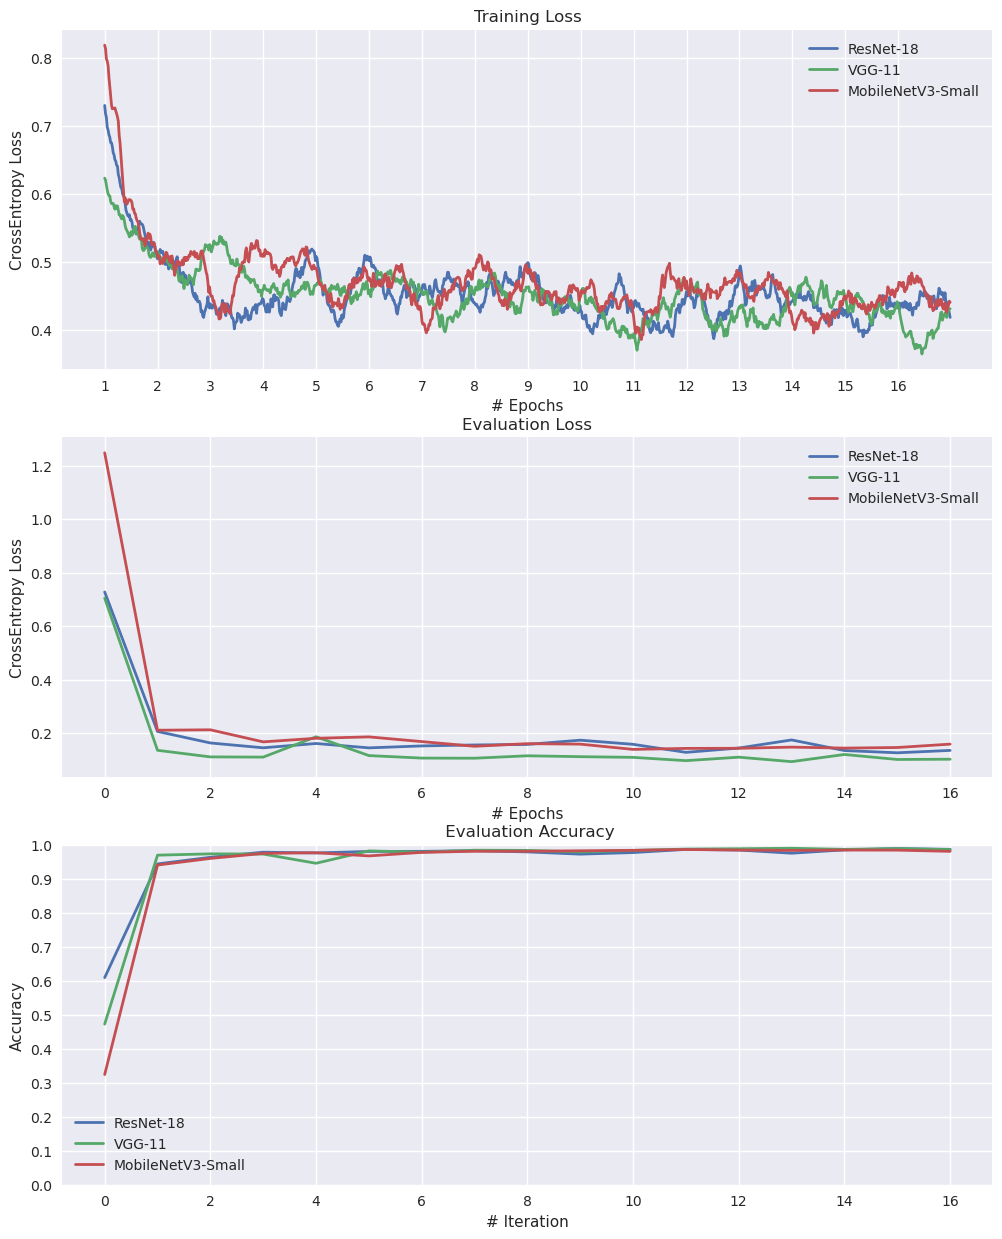

In [23]:
logger_list = [resnet_logger, vgg_logger, mbnet_logger]
names = ['ResNet-18', 'VGG-11', 'MobileNetV3-Small']

tg.visualization.compare_training_results(logger_list, names, RESNET_MODEL_CONFIG)

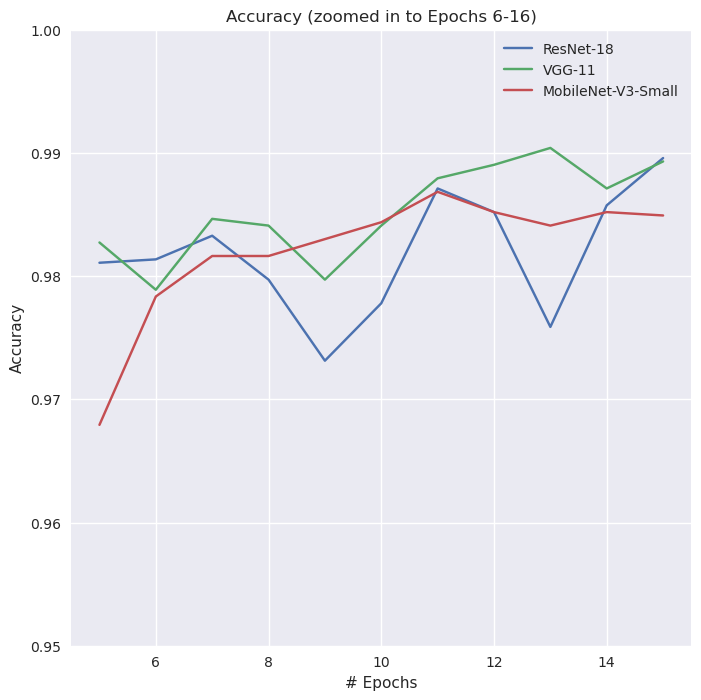

In [24]:
resnet_acc = resnet_logger.get_log()['accuracy']

vgg_acc = vgg_logger.get_log()['accuracy']

mobilenet_acc = mbnet_logger.get_log()['accuracy']


plot_data = [resnet_acc, vgg_acc, mobilenet_acc]

zoom_range = (5,16)
x = np.arange(zoom_range[0], zoom_range[1], 1)
labels = ['ResNet-18', 'VGG-11', 'MobileNet-V3-Small']

fig, ax = plt.subplots(1, 1,figsize=(8,8))

for i, d in enumerate(plot_data):
    ax.plot(x, d[zoom_range[0]:zoom_range[1]], label=labels[i])

ax.set_title('Accuracy (zoomed in to Epochs 6-16)')
ax.set_xlabel('# Epochs')
ax.set_ylabel('Accuracy')
ax.set_ylim(0.95, 1.0)
ax.legend()


#### Model Comparison

The final results, show that the data augmentation techniques did not improve the initially very good models. Overall we can say the the MobileNetV3 performed best.

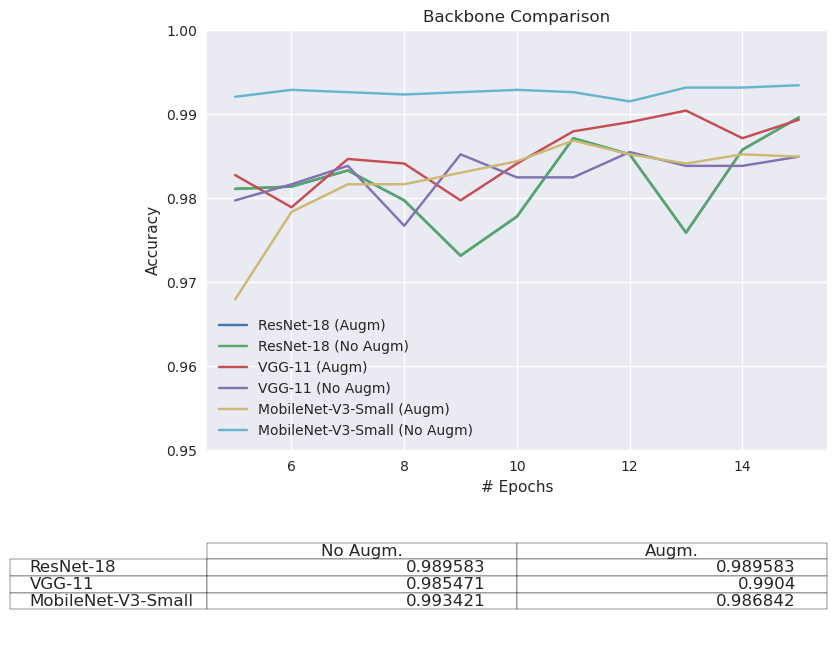

In [25]:


resnet_acc = resnet_logger.get_log()['accuracy']

resnet_noag_acc = resnet_logger.get_log()['accuracy']

vgg_acc = vgg_logger.get_log()['accuracy']

vgg_noag_acc = vgg_noag_logger.get_log()['accuracy']

mobilenet_acc = mbnet_logger.get_log()['accuracy']

mobilenet_noag_acc = mbnet_noag_logger.get_log()['accuracy']

plot_data = [resnet_acc, resnet_noag_acc, vgg_acc, vgg_noag_acc, mobilenet_acc, mobilenet_noag_acc]


table_data = [[round(max(resnet_noag_acc), 6) , round(max(resnet_acc), 6)], 
        [round(max(vgg_noag_acc), 6), round(max(vgg_acc), 4)], 
        [round(max(mobilenet_noag_acc), 6), round(max(mobilenet_acc), 6)]]

zoom_range = (5,16)
x = np.arange(zoom_range[0], zoom_range[1], 1)
labels = ['ResNet-18 (Augm)', 'ResNet-18 (No Augm)', 'VGG-11 (Augm)', 'VGG-11 (No Augm)', 'MobileNet-V3-Small (Augm)', 'MobileNet-V3-Small (No Augm)']

fig, ax = plt.subplots(2, 1,figsize=(8,8), gridspec_kw={'height_ratios': [3, 1]})

for i, d in enumerate(plot_data):
    ax[0].plot(x, d[zoom_range[0]:zoom_range[1]], label=labels[i])

ax[0].set_title('Backbone Comparison')
ax[0].set_xlabel('# Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim(0.95, 1.0)
ax[0].legend()

table = ax[1].table(cellText=table_data, rowLabels=['ResNet-18', 'VGG-11', 'MobileNet-V3-Small'], colLabels = ['No Augm.', 'Augm.'], loc='center')
ax[1].axis('off')
# Set the font size
table.auto_set_font_size(False)
table.set_fontsize(12)
fig.show()

#### Data Augmentation
Here we show the training progress for the models with and without data augmentation exemplarily for the MobileNetV3. We can see that the data augmentation makes the training dataset significantly harder. The loss on the training dataset with data augmentations is significantly higher. The data augmentation seems to not improve the performance.

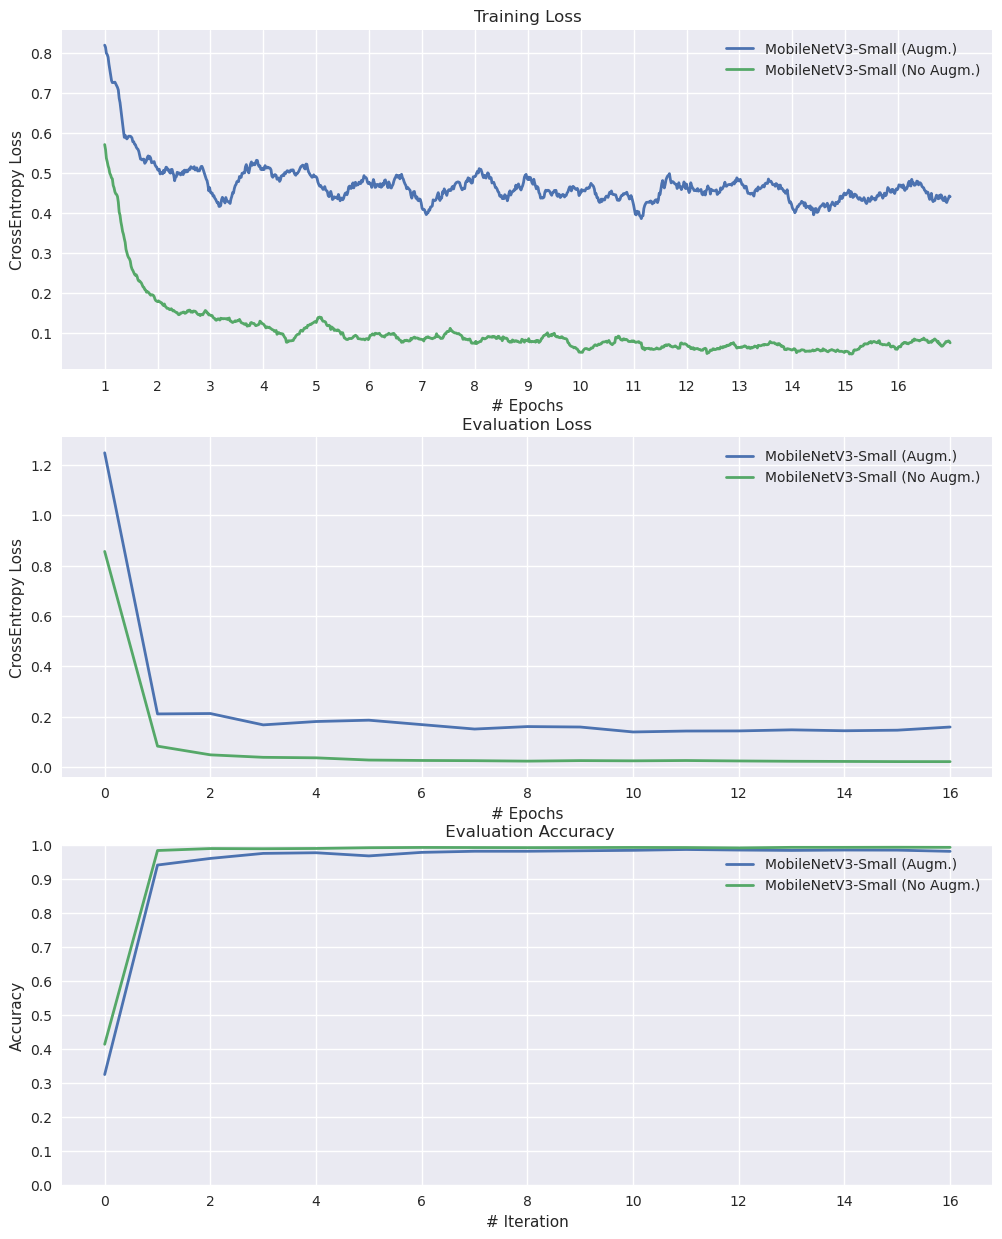

In [26]:
logger_list = [mbnet_logger, mbnet_noag_logger]
names = ['MobileNetV3-Small (Augm.)', 'MobileNetV3-Small (No Augm.)']

tg.visualization.compare_training_results(logger_list, names, RESNET_MODEL_CONFIG)

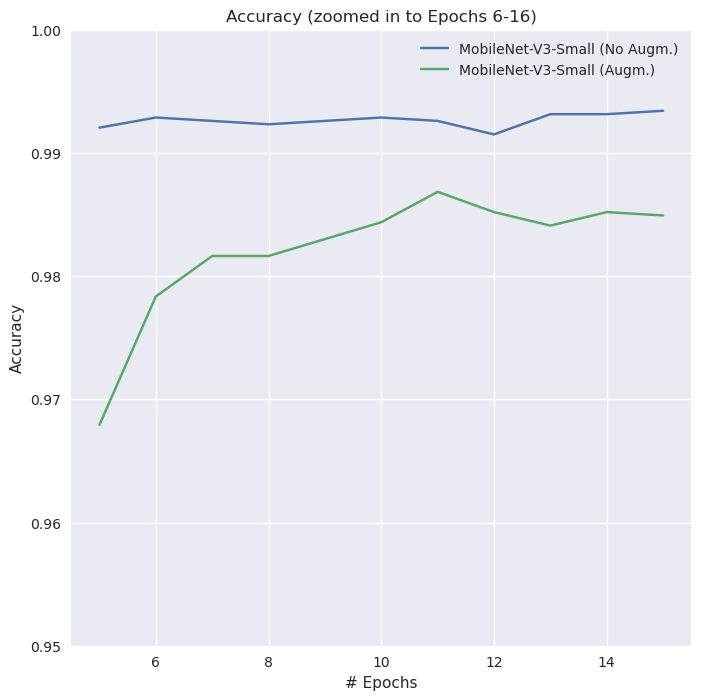

In [27]:


mobilenet_acc = mbnet_logger.get_log()['accuracy']
mobilenet_noag_acc = mbnet_noag_logger.get_log()['accuracy']



plot_data = [mobilenet_noag_acc, mobilenet_acc]

zoom_range = (5,16)
x = np.arange(zoom_range[0], zoom_range[1], 1)
labels = ['MobileNet-V3-Small (No Augm.)', 'MobileNet-V3-Small (Augm.)']

fig, ax = plt.subplots(1, 1,figsize=(8,8))

for i, d in enumerate(plot_data):
    ax.plot(x, d[zoom_range[0]:zoom_range[1]], label=labels[i])

ax.set_title('Accuracy (zoomed in to Epochs 6-16)')
ax.set_xlabel('# Epochs')
ax.set_ylabel('Accuracy')
ax.set_ylim(0.95, 1.0)
ax.legend()

## Task 2: ResNet Training Experiments

In [28]:

EXP_EPOCHS = 16


data_augmentation =   [   
                        #{'type': 'cutmix', 'alpha': 300, 'prob': 0.2, 'beta': 1.0, 'num_classes': 2, 'train': True, 'eval': False},
                        {'type': 'mixup', 'alpha': 1.0, 'prob': 0.4, 'beta': 1.0, 'num_classes': 2, 'train': True, 'eval': False},
                        {'type': 'random_rotation','degrees': 5, 'train': True, 'eval': False},
                        {'type': 'random_horizontal_flip','prob': 0.3, 'train': True, 'eval': False},
                        {'type': 'color_jitter', 'brightness': 0.4, 'contrast': 0.4, 'saturation': 0.3, 'hue': 0.0, 'train': True, 'eval': False},
                        {'type': 'gaussian_blur', 'kernel_size':(5,5), 'sigma': (0.1,2.0), 'train': True, 'eval': False},
                        {'type': 'normalize', 'train': True, 'eval': True},
                    ]

RESNET_MODEL_ARCHITECTURE =     [
                                    {'type': 'ResNet', 'size': 18, 'remove_layer': 1, 'weights': 'DEFAULT'},
                                    {'type': 'flatten'},
                                    {'type': 'dropout', 'prob': 0.3},
                                    {'type': 'linear', 'in_features': tg.models.RESNET_FEATURE_DIM[18][1], 'out_features': 2}
                                ]


RESNET_MODEL_CONFIG =  {
                            'layers': RESNET_MODEL_ARCHITECTURE,
                            'output_dim': 2,
                            'activation': 'relu',
                            'batch_size': 32,
                            'num_epochs': EXP_EPOCHS,
                            'num_iterations': 0,
                            'learning_rate': 0.00003,
                            'random_seed': 22,
                            'pre_processing': data_augmentation,
                            'evaluation': {
                                'metrics': ['accuracy'],
                                'frequency': 1
                            },
                            'dataset': {
                                    'name': 'oxfordpets',
                                    'train_size': 2000,
                                    'val_size': 0,
                                    'test_size': 3669,
                                    'train_shuffle': True,
                                    'eval_shuffle': False,
                                    'drop_last': True,
                                    'classes': [0, 1]
                            },
                            'scheduler': {'epoch_scheduler': {'type': 'exponential', 'gamma': 0.9}, 'iteration_scheduler': None},
                            'optimizer': {'type': 'Adam'}
                            
                        }
RESNET_MODEL_CONFIG['num_iterations'] = tg.training.get_num_iterations(RESNET_MODEL_CONFIG)

RESNET_MODEL_CONFIG_NO_AUGM =  {
                            'layers': RESNET_MODEL_ARCHITECTURE,
                            'output_dim': 2,
                            'activation': 'relu',
                            'batch_size': 32,
                            'num_epochs': EXP_EPOCHS,
                            'num_iterations': 0,
                            'learning_rate': 0.00003,
                            'random_seed': 22,
                            'pre_processing': [],
                            'evaluation': {
                                'metrics': ['accuracy'],
                                'frequency': 1
                            },
                            'dataset': {
                                    'name': 'oxfordpets',
                                    'train_size': 2000,
                                    'val_size': 0,
                                    'test_size': 3669,
                                    'train_shuffle': True,
                                    'eval_shuffle': False,
                                    'drop_last': True,
                                    'classes': [0, 1]
                            },
                            'scheduler': {'epoch_scheduler': {'type': 'exponential', 'gamma': 0.9}, 'iteration_scheduler': None},
                            'optimizer': {'type': 'Adam'}
                            
                        }
RESNET_MODEL_CONFIG_NO_AUGM['num_iterations'] = tg.training.get_num_iterations(RESNET_MODEL_CONFIG_NO_AUGM)



In [29]:

train_loader = torch.utils.data.DataLoader(train_augmentation_dataset, batch_size=RESNET_MODEL_CONFIG['batch_size'], shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_augmentation_dataset, batch_size=RESNET_MODEL_CONFIG['batch_size'], shuffle=False, drop_last=True)

### ResNet-18 Fine-Tuned Model

In [30]:
finetuned_logger = tg.logging.Logger(save_dir=tBoard_log_dir['resnet_finetune'], model_config = RESNET_MODEL_CONFIG, save_external=True, save_internal=True)


finetuned_model, finetuned_train_loader, finetuned_test_loader, finetuned_data_augmentor, finetuned_logger = tg.training.trainNN(config=RESNET_MODEL_CONFIG, logger=finetuned_logger, train_loader=train_loader, test_loader=test_loader)


Initial Evluation


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 13.80it/s]


 accuracy: 0.6732456140350878, eval_loss: 0.9461010893512714,

Epoch 1/16


Evaluation:: 100%|██████████| 114/114 [00:10<00:00, 10.45it/s]


accuracy: 0.9786184210526315, eval_loss: 0.13236819951909415, train_loss: 0.4374311566352844

Epoch 2/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 13.07it/s]


accuracy: 0.9739583333333334, eval_loss: 0.16746900278029211, train_loss: 0.6553047299385071

Epoch 3/16


Evaluation:: 100%|██████████| 114/114 [00:11<00:00, 10.06it/s]


accuracy: 0.9761513157894737, eval_loss: 0.17985024933882973, train_loss: 0.3127171993255615

Epoch 4/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.88it/s]


accuracy: 0.9766995614035088, eval_loss: 0.17322487524596222, train_loss: 0.4835112392902374

Epoch 5/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 13.05it/s]


accuracy: 0.9868421052631579, eval_loss: 0.13664494324148746, train_loss: 0.4280247986316681

Epoch 6/16


Evaluation:: 100%|██████████| 114/114 [00:10<00:00, 10.43it/s]


accuracy: 0.984375, eval_loss: 0.15468350771749229, train_loss: 0.5740160942077637

Epoch 7/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 13.10it/s]


accuracy: 0.9830043859649122, eval_loss: 0.15450240125912323, train_loss: 0.4807131886482239

Epoch 8/16


Evaluation:: 100%|██████████| 114/114 [00:10<00:00, 11.03it/s]


accuracy: 0.9865679824561403, eval_loss: 0.1583926678357417, train_loss: 0.28480076789855957

Epoch 9/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.60it/s]


accuracy: 0.9810855263157895, eval_loss: 0.16155329794345194, train_loss: 0.18677423894405365

Epoch 10/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 13.04it/s]


accuracy: 0.9851973684210527, eval_loss: 0.1489383447261756, train_loss: 0.6327137351036072

Epoch 11/16


Evaluation:: 100%|██████████| 114/114 [00:12<00:00,  9.49it/s]


accuracy: 0.9849232456140351, eval_loss: 0.1608964230930596, train_loss: 0.47910505533218384

Epoch 12/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.81it/s]


accuracy: 0.9879385964912281, eval_loss: 0.13311586836189554, train_loss: 0.46598926186561584

Epoch 13/16


Evaluation:: 100%|██████████| 114/114 [00:10<00:00, 10.45it/s]


accuracy: 0.9876644736842105, eval_loss: 0.15263610097922778, train_loss: 0.6457028388977051

Epoch 14/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.50it/s]


accuracy: 0.9838267543859649, eval_loss: 0.15990169748271765, train_loss: 0.4899265766143799

Epoch 15/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.32it/s]


accuracy: 0.9887609649122807, eval_loss: 0.14383668916528686, train_loss: 0.16760030388832092

Epoch 16/16


Evaluation:: 100%|██████████| 114/114 [00:12<00:00,  9.49it/s]

accuracy: 0.9890350877192983, eval_loss: 0.14522739797177023, train_loss: 0.43635016679763794


### ResNet-18 Fixed Model

In [31]:
freeze_model = tg.models.NeuralNetwork(RESNET_MODEL_CONFIG['layers'])
freeze_model.freeze_backbone_model()

freeze_logger = tg.logging.Logger(save_dir=tBoard_log_dir['resnet_freeze'], model_config = RESNET_MODEL_CONFIG, save_external=True, save_internal=True)

freeze_model, freeze_train_loader, freeze_test_loader, freeze_data_augmentor, freeze_logger = tg.training.trainNN(config=RESNET_MODEL_CONFIG, train_loader=train_loader, test_loader=test_loader)


Initial Evluation


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.96it/s]


 accuracy: 0.6526864035087719, eval_loss: 0.6330846363776609,

Epoch 1/16


Evaluation:: 100%|██████████| 114/114 [00:10<00:00, 10.94it/s]


accuracy: 0.9610745614035088, eval_loss: 0.18630896459676718, train_loss: 0.6804101467132568

Epoch 2/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.71it/s]


accuracy: 0.9624451754385965, eval_loss: 0.20919429193855377, train_loss: 0.5071685314178467

Epoch 3/16


Evaluation:: 100%|██████████| 114/114 [00:11<00:00, 10.16it/s]


accuracy: 0.9802631578947368, eval_loss: 0.1523820424550458, train_loss: 0.6040719747543335

Epoch 4/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.72it/s]


accuracy: 0.9775219298245614, eval_loss: 0.15932557914863554, train_loss: 0.5963701605796814

Epoch 5/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 13.80it/s]


accuracy: 0.9857456140350878, eval_loss: 0.13543500793738322, train_loss: 0.3238750696182251

Epoch 6/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 13.06it/s]


accuracy: 0.9851973684210527, eval_loss: 0.14624050194234178, train_loss: 0.5019233226776123

Epoch 7/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.54it/s]


accuracy: 0.9841008771929824, eval_loss: 0.16121450363936132, train_loss: 0.3437058627605438

Epoch 8/16


Evaluation:: 100%|██████████| 114/114 [00:11<00:00,  9.91it/s]


accuracy: 0.987390350877193, eval_loss: 0.15300129638298562, train_loss: 0.505278468132019

Epoch 9/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.62it/s]


accuracy: 0.9887609649122807, eval_loss: 0.13550982372671888, train_loss: 0.2926074266433716

Epoch 10/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.82it/s]


accuracy: 0.9786184210526315, eval_loss: 0.157137330523447, train_loss: 0.5547686815261841

Epoch 11/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.48it/s]


accuracy: 0.9786184210526315, eval_loss: 0.14951633096656256, train_loss: 0.42212092876434326

Epoch 12/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 13.22it/s]


accuracy: 0.9860197368421053, eval_loss: 0.1329153966681476, train_loss: 0.5987296104431152

Epoch 13/16


Evaluation:: 100%|██████████| 114/114 [00:10<00:00, 10.91it/s]


accuracy: 0.9884868421052632, eval_loss: 0.12907342132376998, train_loss: 0.46865934133529663

Epoch 14/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 13.18it/s]


accuracy: 0.9879385964912281, eval_loss: 0.12851413136772943, train_loss: 0.2368258535861969

Epoch 15/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 13.46it/s]


accuracy: 0.9797149122807017, eval_loss: 0.1577902788525088, train_loss: 0.536290168762207

Epoch 16/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.76it/s]

accuracy: 0.9876644736842105, eval_loss: 0.1275622656797631, train_loss: 0.28526929020881653


### ResNet-18 Combined Model

In [32]:
combined_model = tg.models.NeuralNetwork(RESNET_MODEL_CONFIG['layers'])
combined_model.freeze_backbone_model()

combined_config = copy.deepcopy(RESNET_MODEL_CONFIG)
combined_config['num_epochs'] = int(combined_config['num_epochs'] / 2)

combined_logger = tg.logging.Logger(save_dir=tBoard_log_dir['resnet_combined'], model_config = RESNET_MODEL_CONFIG, save_external=True, save_internal=True)

combined_model, combined_train_loader, combined_test_loader, combined_data_augmentor, combined_logger = tg.training.trainNN(config=combined_config, logger=combined_logger, train_loader=train_loader, test_loader=test_loader)

Initial Evluation


Evaluation:: 100%|██████████| 114/114 [00:10<00:00, 10.52it/s]


 accuracy: 0.3256578947368421, eval_loss: 0.9490981590852403,

Epoch 1/8


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.71it/s]


accuracy: 0.9550438596491229, eval_loss: 0.19883668010956362, train_loss: 0.4777323007583618

Epoch 2/8


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 13.21it/s]


accuracy: 0.9643640350877193, eval_loss: 0.15609831179966005, train_loss: 0.5353240370750427

Epoch 3/8


Evaluation:: 100%|██████████| 114/114 [00:11<00:00,  9.84it/s]


accuracy: 0.9660087719298246, eval_loss: 0.18499483824952653, train_loss: 0.5281166434288025

Epoch 4/8


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.59it/s]


accuracy: 0.9520285087719298, eval_loss: 0.20736162727208515, train_loss: 0.4000575542449951

Epoch 5/8


Evaluation:: 100%|██████████| 114/114 [00:10<00:00, 10.71it/s]


accuracy: 0.9810855263157895, eval_loss: 0.16857641909206122, train_loss: 0.4586544632911682

Epoch 6/8


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.81it/s]


accuracy: 0.9805372807017544, eval_loss: 0.15885657405382708, train_loss: 0.4061000645160675

Epoch 7/8


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 13.22it/s]


accuracy: 0.9772478070175439, eval_loss: 0.16103945581013696, train_loss: 0.1982707679271698

Epoch 8/8


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 11.82it/s]

accuracy: 0.9816337719298246, eval_loss: 0.1594996493832584, train_loss: 0.4080071747303009


In [33]:
combined_model.unfreeze_backbone_model()

combined_config['learning_rate'] *= 0.1
combined_model, combined_train_loader, combined_test_loader, combined_data_augmentor, combined_logger = tg.training.trainNN(config=combined_config,
                                                                                                                            model=combined_model,
                                                                                                                            train_loader=combined_train_loader,
                                                                                                                            test_loader=combined_test_loader,
                                                                                                                            data_augmentor=combined_data_augmentor,
                                                                                                                            logger = combined_logger)

Initial Evluation


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 11.65it/s]


 accuracy: 0.9816337719298246, eval_loss: 0.1594996493832584, train_loss: 0.4080071747303009,

Epoch 1/8


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.80it/s]


accuracy: 0.9862938596491229, eval_loss: 0.15459350839649377, train_loss: 0.6055788993835449

Epoch 2/8


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 13.43it/s]


accuracy: 0.9851973684210527, eval_loss: 0.1445852045558001, train_loss: 0.47624802589416504

Epoch 3/8


Evaluation:: 100%|██████████| 114/114 [00:11<00:00,  9.71it/s]


accuracy: 0.9860197368421053, eval_loss: 0.1473597232905919, train_loss: 0.4149165749549866

Epoch 4/8


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.98it/s]


accuracy: 0.9758771929824561, eval_loss: 0.1742613408387753, train_loss: 0.5108310580253601

Epoch 5/8


Evaluation:: 100%|██████████| 114/114 [00:11<00:00, 10.27it/s]


accuracy: 0.9797149122807017, eval_loss: 0.16853327196287482, train_loss: 0.26546889543533325

Epoch 6/8


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 13.17it/s]


accuracy: 0.9756030701754386, eval_loss: 0.17498955094631305, train_loss: 0.4494026303291321

Epoch 7/8


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.57it/s]


accuracy: 0.9692982456140351, eval_loss: 0.18802676911939653, train_loss: 0.2050144374370575

Epoch 8/8


Evaluation:: 100%|██████████| 114/114 [00:11<00:00,  9.78it/s]

accuracy: 0.9857456140350878, eval_loss: 0.1503394367663484, train_loss: 0.17290207743644714


### Evaluation

All models perform similarily well and achieve an accuracy of ~98%. All models despite the backbone being not being trained seem to learn the task in the same manner. In the combined model the training technique is switched after the model already converge to a local minmum such that including the backbone in the training pipeline does not have a big effect.

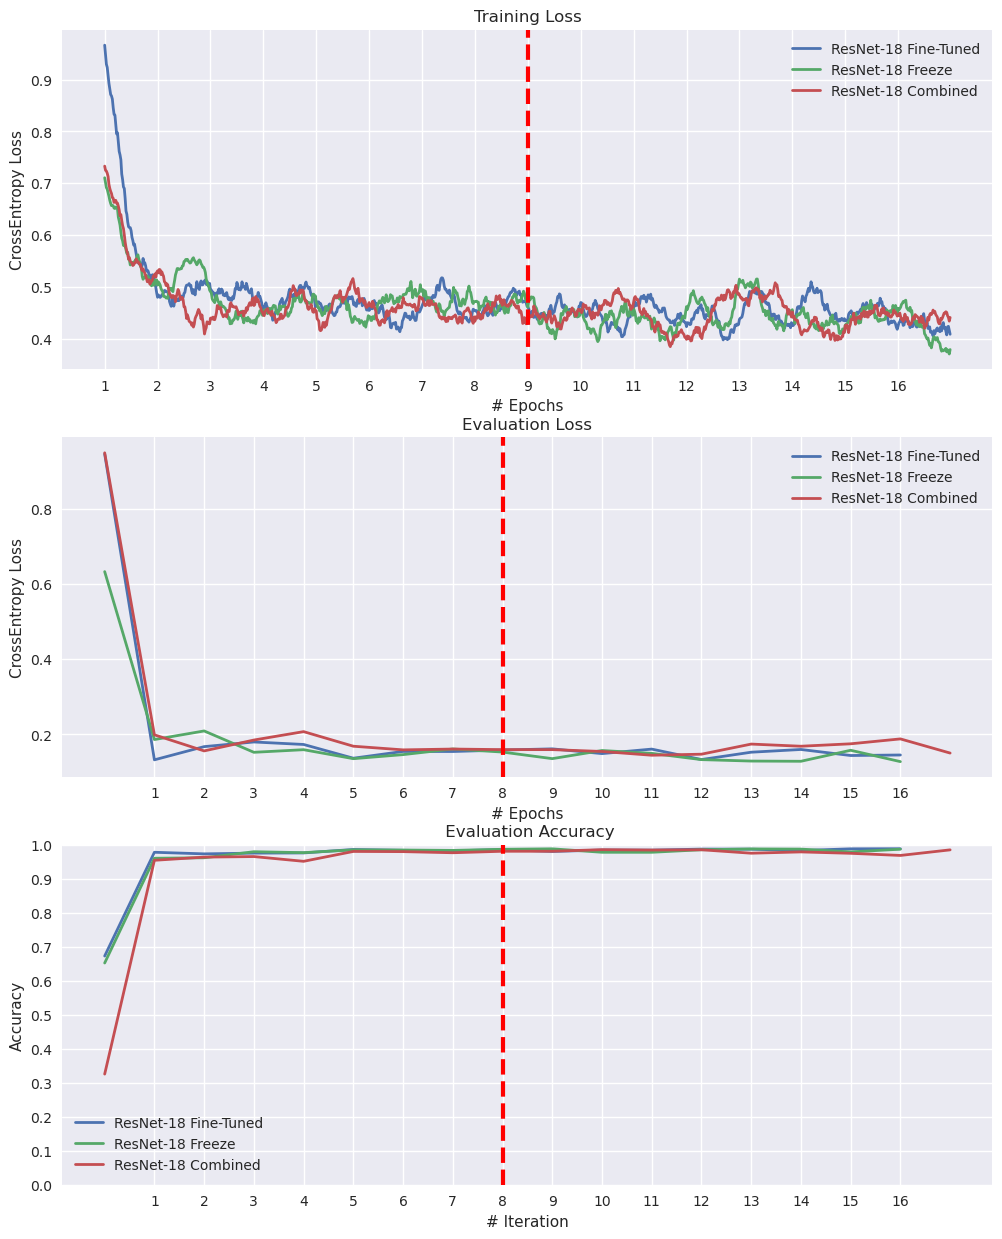

In [34]:
def compare_training_results(logger_list: list, model_names: list, config: dict):
    assert len(logger_list)==len(model_names), f'Length of logger list {len(logger_list)} does not correspond to the length of the mode list {len(model_names)}'
    #iteration_corrected = [np.sum(np.arange(i)*config['num_iterations']) for i in range(config['num_epochs']+1)]
    xticks = range(0, config['num_epochs']*config['num_iterations'], config['num_iterations'])
    plt.style.use('seaborn-v0_8')
    # Load the data from the MLP training
    data = []
    train_loss = []
    eval_loss = []
    eval_acc = []
    for logger in logger_list:
        data = logger.get_log()
        train_loss.append(data['train_loss'])
        eval_loss.append(data['eval_loss'])
        eval_acc.append(data['accuracy'])
    fig = plt.figure(figsize=(12,15))

    ax1 = fig.add_subplot(311)
    for i in range(len(logger_list)):
        smooth_loss = tg.visualization.smooth_curve(train_loss[i], 31)
        ax1.plot(smooth_loss, label=model_names[i], linewidth=2)

    ax1.set_xlabel("# Epochs")
    ax1.set_xticks(xticks, np.arange(1, config['num_epochs']+1))
    ax1.set_ylabel("CrossEntropy Loss")
    ax1.set_title('Training Loss')
    ax1.legend()
    ax1.axvline(x=8*config['num_iterations'], color="red", ls="--", linewidth=3)


    ax2 = fig.add_subplot(312)
    for i in range(len(logger_list)):
        ax2.plot(eval_loss[i], label=model_names[i], linewidth=2)

    ax2.set_xlabel("# Epochs")
    ax2.set_ylabel("CrossEntropy Loss")
    ax2.set_title('Evaluation Loss')
    ax2.set_xticks(np.arange(1, config['num_epochs']+1))
    ax2.legend()
    ax2.axvline(x=8, color="red", ls="--", linewidth=3)


    ax3 = fig.add_subplot(313)
    for i in range(len(logger_list)):
        ax3.plot(eval_acc[i], label=model_names[i], linewidth=2)

    ax3.set_ylim(0.0,1.0)
    ax3.set_yticks(np.arange(0.0, 1.1, 0.1).tolist())
    ax3.set_xlabel("# Iteration")
    ax3.set_ylabel("Accuracy")
    ax3.set_xticks(np.arange(1, config['num_epochs']+1))
    ax3.set_title(' Evaluation Accuracy')
    ax3.legend()
    ax3.axvline(x=8, color="red", ls="--", linewidth=3)



logger_list = [finetuned_logger, freeze_logger, combined_logger]
names = ['ResNet-18 Fine-Tuned', 'ResNet-18 Freeze', 'ResNet-18 Combined']

compare_training_results(logger_list, names, RESNET_MODEL_CONFIG)

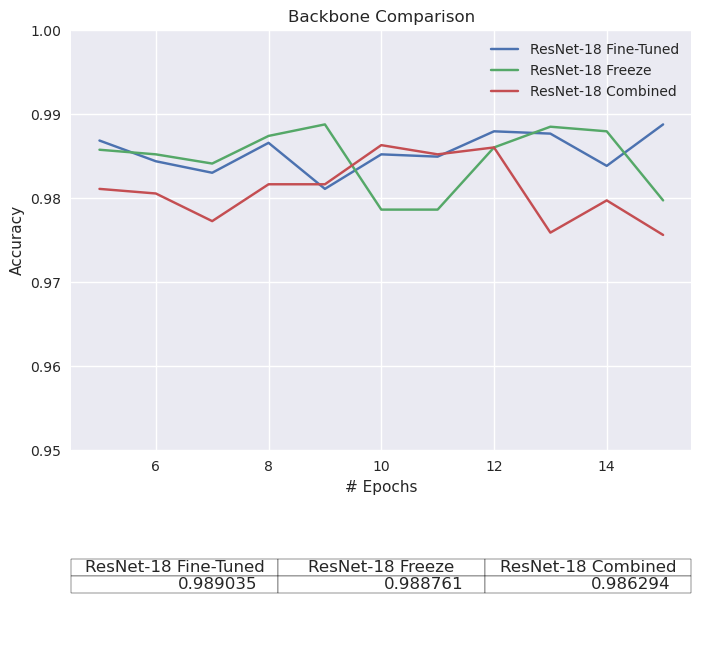

In [35]:

fine_tuned_acc = finetuned_logger.get_log()['accuracy']
freeze_acc = freeze_logger.get_log()['accuracy']
combined_acc = combined_logger.get_log()['accuracy']


plot_data = [fine_tuned_acc, freeze_acc, combined_acc]


labels = ['ResNet-18 Fine-Tuned', 'ResNet-18 Freeze', 'ResNet-18 Combined']

table_data = [[round(max(fine_tuned_acc), 6) , round(max(freeze_acc), 6), round(max(combined_acc), 6)]]
zoom_range = (5,16)
x = np.arange(zoom_range[0], zoom_range[1], 1)

fig, ax = plt.subplots(2, 1,figsize=(8,8), gridspec_kw={'height_ratios': [3, 1]})

for i, d in enumerate(plot_data):
    ax[0].plot(x, d[zoom_range[0]:zoom_range[1]], label=labels[i])

ax[0].set_title('Backbone Comparison')
ax[0].set_xlabel('# Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim(0.95, 1.0)
ax[0].legend()

table = ax[1].table(cellText=table_data, colLabels=['ResNet-18 Fine-Tuned', 'ResNet-18 Freeze', 'ResNet-18 Combined'], loc='center')
ax[1].axis('off')
# Set the font size
table.auto_set_font_size(False)
table.set_fontsize(12)
fig.show()

## Bonus Task: Transform-based Model
Here we simply took the VisualTransformer model with the same data augmentation and config as the ResNet-18. We did not further tune the hyper parameters which is highly likely to be the reason for the poor performance of the VisualTransformer. In our case the ResNet-18 performs better in any metric. Unfortunately we ran out of time to further investigate this problem.

In [36]:
EXP_EPOCHS = 16


data_augmentation =   [   
                        #{'type': 'cutmix', 'alpha': 300, 'prob': 0.2, 'beta': 1.0, 'num_classes': 2, 'train': True, 'eval': False},
                        {'type': 'mixup', 'alpha': 1.0, 'prob': 0.4, 'beta': 1.0, 'num_classes': 2, 'train': True, 'eval': False},
                        {'type': 'random_rotation','degrees': 5, 'train': True, 'eval': False},
                        {'type': 'random_horizontal_flip','prob': 0.3, 'train': True, 'eval': False},
                        {'type': 'color_jitter', 'brightness': 0.4, 'contrast': 0.4, 'saturation': 0.3, 'hue': 0.0, 'train': True, 'eval': False},
                        {'type': 'gaussian_blur', 'kernel_size':(5,5), 'sigma': (0.1,2.0), 'train': True, 'eval': False},
                        {'type': 'normalize', 'train': True, 'eval': True},
                    ]

VIT_MODEL_ARCHITECTURE =     [
                                    {'type': 'ViT', 'size': 'b_16', 'remove_layer': 1, 'weights': 'DEFAULT'},
                                    {'type': 'flatten'},
                                    {'type': 'dropout', 'prob': 0.3},
                                    {'type': 'linear', 'in_features': 150528, 'out_features': 2}
                                ]


VIT_MODEL_CONFIG =  {
                            'layers': VIT_MODEL_ARCHITECTURE,
                            'output_dim': 2,
                            'activation': 'relu',
                            'batch_size': 32,
                            'num_epochs': EXP_EPOCHS,
                            'num_iterations': 0,
                            'learning_rate': 0.00003,
                            'random_seed': 22,
                            'pre_processing': data_augmentation,
                            'evaluation': {
                                'metrics': ['accuracy'],
                                'frequency': 1
                            },
                            'dataset': {
                                    'name': 'oxfordpets',
                                    'train_size': 2000,
                                    'val_size': 0,
                                    'test_size': 3669,
                                    'train_shuffle': True,
                                    'eval_shuffle': False,
                                    'drop_last': True,
                                    'classes': [0, 1]
                            },
                            'scheduler': {'epoch_scheduler': {'type': 'exponential', 'gamma': 0.9}, 'iteration_scheduler': None},
                            'optimizer': {'type': 'Adam'}
                            
                        }

In [37]:
vit_logger = tg.logging.Logger(save_dir=tBoard_log_dir['resnet_finetune'], model_config = VIT_MODEL_CONFIG, save_external=True, save_internal=True)


vit_model, vit_train_loader, vit_test_loader, vit_data_augmentor, vit_logger = tg.training.trainNN(config=VIT_MODEL_CONFIG, logger=vit_logger, train_loader=train_loader, test_loader=test_loader)


Initial Evluation


Evaluation:: 100%|██████████| 114/114 [00:05<00:00, 20.90it/s]


 accuracy: 0.4725877192982456, eval_loss: 0.8011251008301451,

Epoch 1/16


Evaluation:: 100%|██████████| 114/114 [00:05<00:00, 19.71it/s]


accuracy: 0.5405701754385965, eval_loss: 0.8678411078034786, train_loss: 0.8585622906684875

Epoch 2/16


Evaluation:: 100%|██████████| 114/114 [00:05<00:00, 19.71it/s]


accuracy: 0.5117872807017544, eval_loss: 0.7755120171789538, train_loss: 0.8221544623374939

Epoch 3/16


Evaluation:: 100%|██████████| 114/114 [00:05<00:00, 21.21it/s]


accuracy: 0.5370065789473685, eval_loss: 0.7997776607149526, train_loss: 0.761198878288269

Epoch 4/16


Evaluation:: 100%|██████████| 114/114 [00:06<00:00, 18.18it/s]


accuracy: 0.5553728070175439, eval_loss: 0.7872239021878493, train_loss: 0.7453188896179199

Epoch 5/16


Evaluation:: 100%|██████████| 114/114 [00:06<00:00, 18.67it/s]


accuracy: 0.5372807017543859, eval_loss: 0.8012876162926356, train_loss: 0.723655104637146

Epoch 6/16


Evaluation:: 100%|██████████| 114/114 [00:06<00:00, 17.66it/s]


accuracy: 0.5572916666666666, eval_loss: 0.7450972497463226, train_loss: 0.7830528020858765

Epoch 7/16


Evaluation:: 100%|██████████| 114/114 [00:06<00:00, 18.40it/s]


accuracy: 0.5597587719298246, eval_loss: 0.7426588948358569, train_loss: 0.8623236417770386

Epoch 8/16


Evaluation:: 100%|██████████| 114/114 [00:06<00:00, 18.19it/s]


accuracy: 0.5449561403508771, eval_loss: 0.7144367726225602, train_loss: 0.7101260423660278

Epoch 9/16


Evaluation:: 100%|██████████| 114/114 [00:06<00:00, 16.78it/s]


accuracy: 0.5625, eval_loss: 0.7068298187172204, train_loss: 0.848270058631897

Epoch 10/16


Evaluation:: 100%|██████████| 114/114 [00:06<00:00, 17.51it/s]


accuracy: 0.5731907894736842, eval_loss: 0.7121760965439311, train_loss: 0.8659290075302124

Epoch 11/16


Evaluation:: 100%|██████████| 114/114 [00:06<00:00, 17.45it/s]


accuracy: 0.5822368421052632, eval_loss: 0.6927661477473744, train_loss: 0.7240393161773682

Epoch 12/16


Evaluation:: 100%|██████████| 114/114 [00:06<00:00, 17.49it/s]


accuracy: 0.5586622807017544, eval_loss: 0.6933563409144419, train_loss: 0.7113593816757202

Epoch 13/16


Evaluation:: 100%|██████████| 114/114 [00:06<00:00, 18.61it/s]


accuracy: 0.5852521929824561, eval_loss: 0.6821958778197306, train_loss: 0.714191198348999

Epoch 14/16


Evaluation:: 100%|██████████| 114/114 [00:06<00:00, 17.65it/s]


accuracy: 0.5564692982456141, eval_loss: 0.7170243286772778, train_loss: 0.7852325439453125

Epoch 15/16


Evaluation:: 100%|██████████| 114/114 [00:05<00:00, 19.34it/s]


accuracy: 0.5677083333333334, eval_loss: 0.7014054969737404, train_loss: 0.7729763984680176

Epoch 16/16


Evaluation:: 100%|██████████| 114/114 [00:06<00:00, 18.73it/s]

accuracy: 0.5487938596491229, eval_loss: 0.7076904925338009, train_loss: 0.6870161294937134


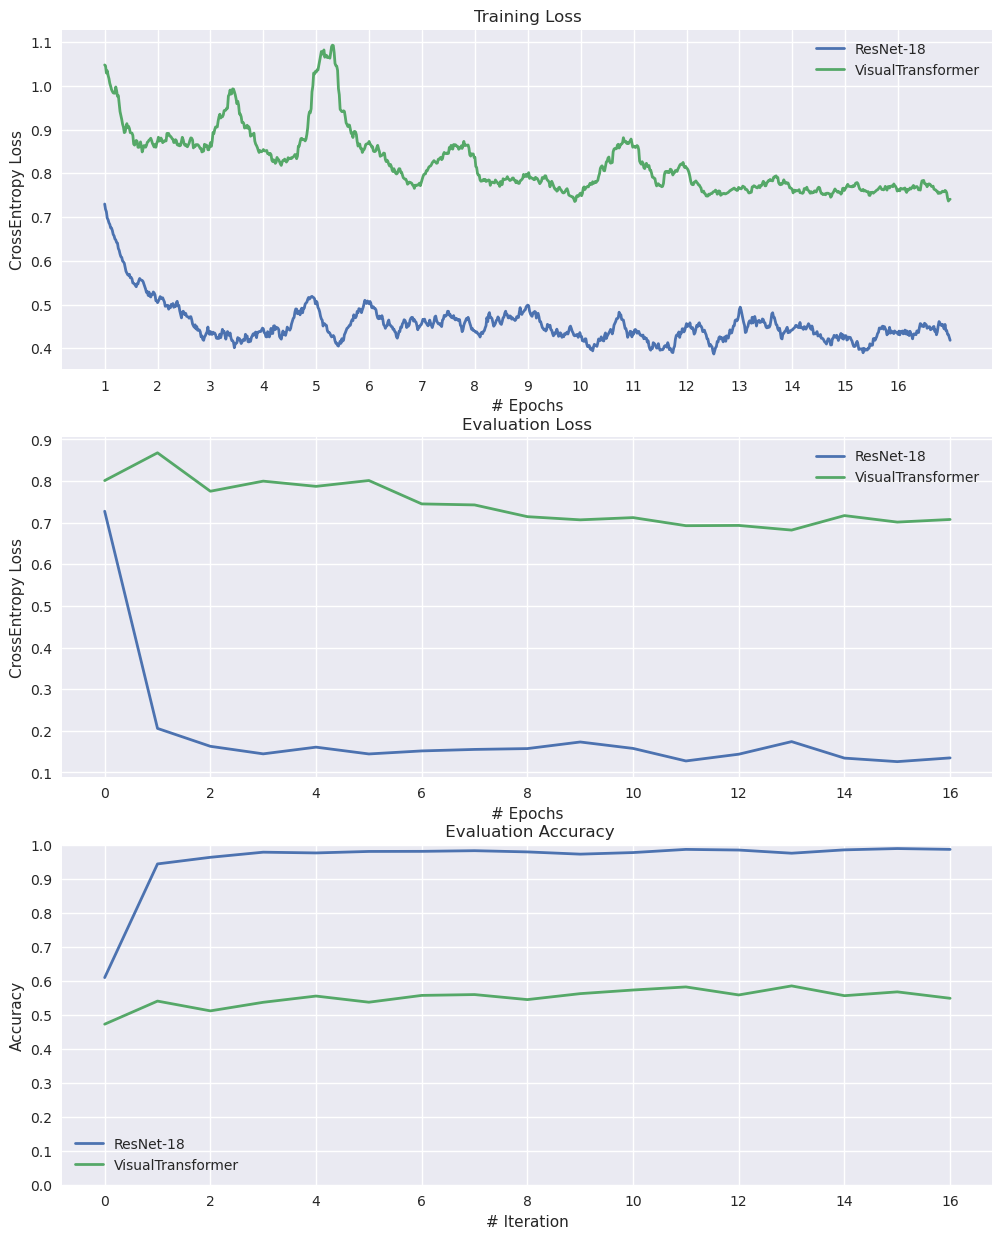

In [39]:
logger_list = [resnet_logger, vit_logger]
names = ['ResNet-18', 'VisualTransformer']

tg.visualization.compare_training_results(logger_list, names, RESNET_MODEL_CONFIG)